In [9]:
# General imports
import os
import sys
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)
import scipy

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

from sklearn.cluster import KMeans

from tqdm import tqdm
# Other imports
tqdm.pandas()

import json

from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches

import random 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=60, progress_bar=True)

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18


INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Previous parts


# UTRs

In [22]:
utrs = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_miso_utrs"])
genes_identical_cds = utrs.loc[utrs['Nb_combi'] == 1].Gene.values.tolist()

In [11]:
genes_path_processed = "/gstock/EXOTIC/data/GENOMICS/refseq_37_processed.parquet"
genes = pd.read_parquet(genes_path_processed)
# genes = genes.loc[~genes['Gene'].isin(genes_identical_cds)]

In [480]:
genes_path_processed = yaml['1_GENOMICS']['Final']['refseq_genes_processed_miso_siso']
genes = pd.read_parquet(genes_path_processed)
genes['OMIM'] = genes['Attributes'].apply(lambda r: [e for e in r.split(';') if 'MIM' in e])
genes_omim =  genes.loc[genes['OMIM'].str.len() > 0]
genes_omim['OMIM'] = genes_omim['OMIM'].apply(lambda r: [e for e in r[0].split(',') if 'MIM:' in e])
genes_omim =  genes_omim.loc[genes_omim['OMIM'].str.len() > 0]
genes_omim['OMIM'] = genes_omim['OMIM'].apply(lambda r: r[0].replace('MIM:', ''))
genes_omim

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Gene,Length,Miso_siso,OMIM
3,NC_000001.10,BestRefSeq,gene,861111,879954,.,+,.,"ID=gene-SAMD11;Dbxref=GeneID:148398,HGNC:HGNC:...",SAMD11,18.843,Siso,616765
4,NC_000001.10,BestRefSeq,gene,879583,894636,.,-,.,"ID=gene-NOC2L;Dbxref=GeneID:26155,HGNC:HGNC:24...",NOC2L,15.053,Siso,610770
7,NC_000001.10,BestRefSeq,gene,910578,917473,.,-,.,"ID=gene-PERM1;Dbxref=GeneID:84808,HGNC:HGNC:28...",PERM1,6.895,Miso,615921
8,NC_000001.10,BestRefSeq,gene,934344,935477,.,-,.,"ID=gene-HES4;Dbxref=GeneID:57801,HGNC:HGNC:241...",HES4,1.133,Miso,608060
9,NC_000001.10,BestRefSeq,gene,948877,949920,.,+,.,"ID=gene-ISG15;Dbxref=GeneID:9636,HGNC:HGNC:405...",ISG15,1.043,Siso,147571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19318,NC_000024.9,BestRefSeq,gene,26979967,27053187,.,+,.,"ID=gene-DAZ4;Dbxref=GeneID:57135,HGNC:HGNC:159...",DAZ4,73.220,Miso,400048
19320,NC_000024.9,BestRefSeq,gene,27768264,27771049,.,+,.,"ID=gene-CDY1;Dbxref=GeneID:9085,HGNC:HGNC:1809...",CDY1,2.785,Miso,400016
19321,NC_000024.9,BestRefSeq,gene,59100403,59115127,.,+,.,"ID=gene-SPRY3-2;Dbxref=GeneID:10251,HGNC:HGNC:...",SPRY3,14.724,Miso,300531
19322,NC_000024.9,BestRefSeq,gene,59214014,59276439,.,+,.,"ID=gene-VAMP7-2;Dbxref=GeneID:6845,HGNC:HGNC:1...",VAMP7,62.425,Miso,300053


# Paralogs


In [3]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

paralogs = pd.read_csv(yaml['2_PARALOGS']['External']['biomart_paralogs'], compression='gzip', sep='\t')
paralogs = paralogs.dropna(subset=['Human paralogue chromosome/scaffold start (bp)'])
# paralogs = paralogs.dropna(subset=['Human paralogue chromosome/scaffold start (bp)', 'Human paralogue gene stable ID'])
paralogs = paralogs.dropna(subset=['Human paralogue associated gene name'])

paralogs = pd.merge(paralogs.rename({'Gene name':'Gene'},axis=1), genes[['Gene', 'Miso_siso']], on='Gene')
paralogs = paralogs.loc[paralogs['Human paralogue homology type'] == 'within_species_paralog']
# paralogs = paralogs.loc[paralogs['Paralogue last common ancestor with Human'] == 'Homo sapiens']
paralogs['Check_paralog'] = paralogs['Human paralogue associated gene name'].apply(lambda r: True if type(r) is str else False)
# paralogs['Association'] = paralogs.apply(lambda r:list(sorted([r['Human paralogue associated gene name'] + r['Gene']])), axis=1)
paralogs

,Gene stable ID,Gene stable ID version,Human paralogue associated gene name,Human paralogue gene stable ID,Human paralogue protein or transcript ID,Human paralogue chromosome/scaffold name,Human paralogue chromosome/scaffold start (bp),Human paralogue chromosome/scaffold end (bp),Paralogue query protein or transcript ID,Paralogue last common ancestor with Human,Human paralogue homology type,Paralogue %id. target Human gene identical to query gene,Paralogue %id. query gene identical to target Human gene,Gene,Miso_siso,Check_paralog
0,ENSG00000233803,ENSG00000233803.9,TSPY10,ENSG00000236424,ENSP00000406407,Y,9527880.0,9530682.0,ENSP00000399668,Homo sapiens,within_species_paralog,98.0892,100.0000,TSPY4,Siso,True
1,ENSG00000233803,ENSG00000233803.9,TSPY3,ENSG00000228927,ENSP00000398163,Y,9398421.0,9401223.0,ENSP00000399668,Homo sapiens,within_species_paralog,98.0892,100.0000,TSPY4,Siso,True
2,ENSG00000233803,ENSG00000233803.9,TSPY9P,ENSG00000238074,ENSP00000499192,Y,9487313.0,9489893.0,ENSP00000399668,Homo sapiens,within_species_paralog,99.6815,99.6815,TSPY4,Siso,True
3,ENSG00000233803,ENSG00000233803.9,TSPY8,ENSG00000229549,ENSP00000287721,Y,9357797.0,9360599.0,ENSP00000399668,Homo sapiens,within_species_paralog,97.4522,99.3506,TSPY4,Siso,True
4,ENSG00000233803,ENSG00000233803.9,TSPY2,ENSG00000168757,ENSP00000314077,Y,6246223.0,6249019.0,ENSP00000399668,Homininae,within_species_paralog,97.4522,99.3506,TSPY4,Siso,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253440,ENSG00000196242,ENSG00000196242.10,OR2J1,ENSG00000204702,ENSP00000493312,6,29099490.0,29102701.0,ENSP00000493385,Theria,within_species_paralog,55.3125,56.7308,OR2C3,Siso,True
253730,ENSG00000196182,ENSG00000196182.11,TRIB3,ENSG00000101255,ENSP00000217233,20,362835.0,397559.0,ENSP00000362224,Chordata,within_species_paralog,23.6782,28.7710,STK40,Miso,True
253731,ENSG00000196182,ENSG00000196182.11,TRIB1,ENSG00000173334,ENSP00000312150,8,125430358.0,125438403.0,ENSP00000362224,Chordata,within_species_paralog,22.7586,26.6129,STK40,Miso,True
253732,ENSG00000196182,ENSG00000196182.11,TRIB2,ENSG00000071575,ENSP00000155926,2,12716910.0,12742734.0,ENSP00000362224,Chordata,within_species_paralog,22.0690,27.9883,STK40,Miso,True


In [25]:
paralogs.Gene.nunique()

5801

In [ ]:
genes_not_in_refseq = paralogs.loc[~paralogs['Gene'].isin(set(paralogs['Human paralogue associated gene name'].values.tolist()).intersection(set(genes.Gene.values.tolist())))].Gene.values.tolist()
paralogs = paralogs.loc[~paralogs['Gene'].isin(genes_not_in_refseq)]
paralogs

In [27]:
len(set(paralogs.Gene.values.tolist()).intersection(set(genes.Gene.values.tolist())))

5586

In [28]:
paralogs[['Gene', 'Miso_siso']].drop_duplicates().Miso_siso.value_counts()

Siso    2881
Miso    2705
Name: Miso_siso, dtype: int64

In [37]:
paralogs_count = paralogs.groupby(['Miso_siso', 'Gene'])['Check_paralog'].value_counts().rename('count').reset_index()
# test.loc[test['Check_paralog'] > 1]
paralogs_count
# test

,Miso_siso,Gene,Check_paralog,count
0,Miso,A4GALT,True,1
1,Miso,AAMP,True,1
2,Miso,AATK,True,1
3,Miso,ABCD3,True,3
4,Miso,ABCD4,True,3
...,...,...,...,...
6233,Siso,ZSWIM1,True,1
6234,Siso,ZSWIM3,True,1
6235,Siso,ZXDA,True,1
6236,Siso,ZXDB,True,1


In [30]:
tmp = pd.DataFrame(genes.loc[~genes['Gene'].isin(paralogs.Gene.values.tolist())]['Miso_siso'].value_counts().rename('count'))
# tmp['count'] / tmp['count'].sum()
tmp

,count
Miso,6944
Siso,5492


In [31]:
paralogs_count.groupby('Miso_siso')['count'].describe()['count'] / paralogs_count.groupby('Miso_siso')['count'].describe()['count'].sum()

Miso_siso
Miso    0.484246
Siso    0.515754
Name: count, dtype: float64

In [305]:
paralogs_count.loc[paralogs_count['Gene'].duplicated(keep=False) == True]

,Miso_siso,Gene,Check_paralog,count
42,Miso,ADSL,True,2
43,Miso,ADSL,False,1
64,Miso,AHRR,False,1
65,Miso,AHRR,True,1
85,Miso,ALG9,True,2
...,...,...,...,...
6603,Siso,ZNF98,False,1
6604,Siso,ZNF99,False,1
6605,Siso,ZNF99,True,1
6606,Siso,ZRSR2,True,3


In [32]:
paralogs_count.groupby('Miso_siso')['count'].describe()

,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,2705.0,2.619593,2.719204,1.0,1.0,2.0,3.0,24.0
Siso,2881.0,4.201319,4.734303,1.0,1.0,2.0,5.0,25.0


In [422]:
pd.DataFrame(concat['Miso']).T

,With paralogs,Without paralogs
Miso,3218.0,7728.0


[[2818.0, 2983.0], [6831.0, 5390.0]]
[9649.0, 8373.0, 9649.0, 8373.0]
Rectangle(xy=(-0.25, 0), width=0.5, height=2818, angle=0) 2818.0 [9649.0, 8373.0, 9649.0, 8373.0] 0.2920509897398694
Rectangle(xy=(0.75, 0), width=0.5, height=2983, angle=0) 2983.0 [9649.0, 8373.0, 9649.0, 8373.0] 0.35626418249134123
Rectangle(xy=(-0.25, 2818), width=0.5, height=6831, angle=0) 6831.0 [9649.0, 8373.0, 9649.0, 8373.0] 0.7079490102601306
Rectangle(xy=(0.75, 2983), width=0.5, height=5390, angle=0) 5390.0 [9649.0, 8373.0, 9649.0, 8373.0] 0.6437358175086588


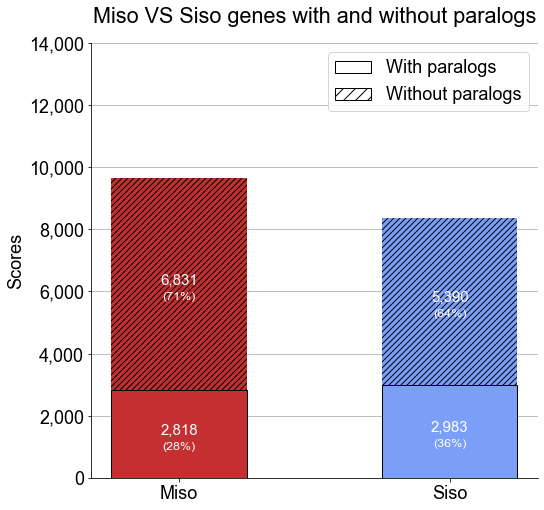

In [168]:
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        s_sum = list()
        sub_list = list()
        i_c = 1
        for p in ax.patches:
            sub_list.append(p.get_height())
            if i_c % 2 == 0:
                s_sum.append(sub_list)
                sub_list = list()
            i_c += 1
        print(s_sum)
        s_sum = zip(s_sum[0], s_sum[1])
        s_sum = [sum(e) for e in s_sum]
        s_sum = s_sum + s_sum
        print(s_sum)
        for j, p in enumerate(ax.patches):
#                 print('\n')
            print(p, p.get_height(), s_sum, float(int(p.get_height())/s_sum[j]))
#                 print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
            ax.text(_x, _y - padding, "(" + str(int(100 * round(float(int(p.get_height())/s_sum[j]), 2))) + '%)', ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

concat = pd.concat([
    pd.DataFrame(paralogs_count.groupby('Miso_siso')['count'].describe()['count'].T.rename('With paralogs')),
    pd.DataFrame(genes.loc[~genes['Gene'].isin(paralogs.Gene.values.tolist())]['Miso_siso'].value_counts().rename('Without paralogs'))
], axis=1
)

labels = concat.index.tolist()
men_means = concat['With paralogs'].values.tolist()
women_means = concat['Without paralogs'].values.tolist()
width = 0.5       # the width of the bars: can also be len(x) sequence

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }

palette_para = {
    "Miso_para" : palette['Miso'],
    "Siso_para" : palette['Siso'],
    "Miso_not_para" : '#F39B7FFF',
    "Siso_not_para" : '#91D1C2FF',
}


fig, ax = plt.subplots(figsize=(8,8))

ax.bar(labels, men_means, width, label='With paralogs', color=[palette_para['Miso_para'], palette_para['Siso_para']],  edgecolor='black')
ax.bar(labels, women_means, width, bottom=men_means, label='Without paralogs', hatch="////", color=[palette_para['Miso_para'],  palette_para['Siso_para']])
ax.set_ylim(0,14e3)
ax.set_ylabel('Scores')
ax.set_title('Miso VS Siso genes with and without paralogs', pad=20)

circ1 = mpatches.Patch( facecolor='white', edgecolor='black', label="With paralogs")
circ2= mpatches.Patch( facecolor='white', edgecolor='black',  hatch="//", label='Without paralogs')
ax.legend(handles=[circ1, circ2], loc='upper right')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
ax.set_axisbelow(True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis='y')
show_values_on_bars(ax, padding=500)

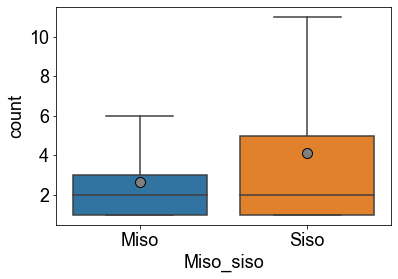

In [320]:
sns.boxplot(data=paralogs_count, x='Miso_siso', y='count', showfliers=False, showmeans=True, meanline=False, 
                    meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})

In [614]:
["{}\n({})".format(k,v) for k,v in paralogs_count.Miso_siso.value_counts().to_dict().items()]

['Miso\n(3218)', 'Siso\n(2952)']

Miso_siso
Miso    2
Siso    2
Name: count, dtype: int64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.421e-36 U_stat=3.998e+06
            count      mean       std  min  25%  50%  75%   max
Miso_siso                                                      
Miso       3255.0  2.636252  2.804275  1.0  1.0  2.0  3.0  24.0
Siso       2983.0  4.100905  4.688650  1.0  1.0  2.0  5.0  25.0


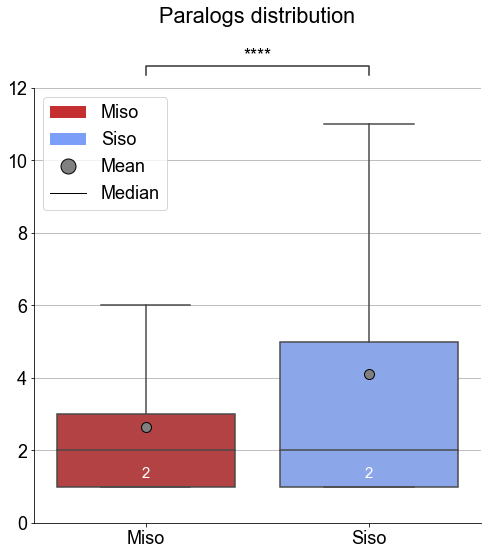

In [39]:

def custom_boxplot(data, x, y, ax, ylim, title="Title", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False):

    if x:
        data = data.sort_values(by=x,ascending=True)
        sns.boxplot(data=data, x=x, y=y, showfliers=False, ax=ax, palette=palette, showmeans=True, meanline=False, 
                    meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
    else:
        sns.boxplot(data=data, y=y, showfliers=False, ax=ax, palette=palette)
        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    update_xlabels = ["{}\n({})".format(k,v) for k,v in paralogs_count.Miso_siso.value_counts().to_dict().items()]
#     ax.set_xticklabels(update_xlabels)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x: 
        ax.spines['bottom'].set_linewidth(0)

        ax.axes.xaxis.set_visible(False)
    ax.set_axisbelow(True)

    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles=handles + 
                  [ 
                    mpatches.Patch( facecolor=palette['Miso']),
                    mpatches.Patch( facecolor=palette['Siso']),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
                    matplotlib.lines.Line2D([0], [0], color='black', lw=1)
                    ],  
              labels=labels + ["Miso", "Siso", 'Mean', "Median"], title='', ncol=1, loc='upper left')
    else:
        ax.legend().remove()

    if x: 
        medians = data.groupby(x)[y].median()
        means = data.groupby(x)[y].mean()
        vertical_offset_median = data[y].median() * 0.15 # offset from median for display
        vertical_offset_mean = data[y].mean() * 0.15 # offset from median for display

        for xtick in ax.get_xticks():
            ax.text(xtick,medians[xtick] - padding_value_boxplot,round(medians[xtick],2), 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
#             ax.text(xtick - 0.2, means[xtick] - 0.05 ,round(means[xtick],2), 
#                     horizontalalignment='center',size='small',color='white',weight='semibold')
    else:
        medians = data[y].median()
        vertical_offset = data[y].median() * 0.15 # offset from median for display
        for xtick in ax.get_xticks():
            ax.text(xtick,medians - padding_value_boxplot,medians, 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
    print(medians)


    
#     ax.spines['right'].set_linewidth(0)

    if x: 
        add_stat_annotation(ax, data=data, x=x, y=y, box_pairs=box_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='outside', verbose=2)
    return ax



f, ax = plt.subplots(figsize=(8,8))

custom_boxplot(paralogs_count,"Miso_siso","count",ax,(0,12),"Paralogs distribution",[("Siso", "Miso")], palette=palette, padding_title=65, padding_value_boxplot=0.75, legend=True)
print(paralogs_count.groupby('Miso_siso')['count'].describe())

In [149]:
genes.drop_duplicates(subset=['Gene'])['Miso_siso'].value_counts()

Miso    10937
Siso     8369
Name: Miso_siso, dtype: int64

In [243]:
paralogs.Gene.nunique()

6527

In [244]:
paralogs.drop_duplicates(subset=['Gene'])['Miso_siso'].value_counts()

Miso    3428
Siso    3099
Name: Miso_siso, dtype: int64

In [245]:
paralogs.drop_duplicates(subset=['Gene'])['Miso_siso'].value_counts() / genes.drop_duplicates(subset=['Gene'])['Miso_siso'].value_counts()

Miso    0.313431
Siso    0.370295
Name: Miso_siso, dtype: float64

In [32]:
paralogs_count_by_cat = pd.merge(genes[['Gene', 'Miso_siso']].rename({'Gene' : 'Gene_tmp', 'Miso_siso' : 'Miso_siso_target'}, axis=1), 
                        paralogs.rename({'Miso_siso' : 'Miso_siso_query'}, axis=1), 
                        left_on='Gene_tmp', right_on='Human paralogue associated gene name')
paralogs_count_by_cat['Association'] = paralogs_count_by_cat.progress_apply(lambda r:"-".join(list(sorted([r['Human paralogue associated gene name'], r['Gene']]))), axis=1)
paralogs_count_by_cat['Cat_Association'] = paralogs_count_by_cat.progress_apply(lambda r:"-".join(list(sorted([r['Miso_siso_target'], r['Miso_siso_query']]))), axis=1)
paralogs_count_by_cat = paralogs_count_by_cat.drop_duplicates(subset=['Association', 'Cat_Association'])
paralogs_count_by_cat

100%|██████████| 20050/20050 [00:00<00:00, 35799.84it/s]


,Gene_tmp,Miso_siso_target,Gene stable ID,Gene stable ID version,Human paralogue associated gene name,Human paralogue gene stable ID,Human paralogue protein or transcript ID,Human paralogue chromosome/scaffold name,Human paralogue chromosome/scaffold start (bp),Human paralogue chromosome/scaffold end (bp),Paralogue query protein or transcript ID,Paralogue last common ancestor with Human,Human paralogue homology type,Paralogue %id. target Human gene identical to query gene,Paralogue %id. query gene identical to target Human gene,Gene,Miso_siso_query,Check_paralog,Association,Cat_Association
0,OR4F5,Siso,ENSG00000176695,ENSG00000176695.8,OR4F5,ENSG00000186092,ENSP00000493376,1,65419.0,71585.0,ENSP00000493422,Homo sapiens,within_species_paralog,99.0798,99.0798,OR4F17,Siso,True,OR4F17-OR4F5,Siso-Siso
1,OR4F5,Siso,ENSG00000177693,ENSG00000177693.5,OR4F5,ENSG00000186092,ENSP00000493376,1,65419.0,71585.0,ENSP00000497674,Homo sapiens,within_species_paralog,98.7616,97.8528,OR4F4,Siso,True,OR4F4-OR4F5,Siso-Siso
2,OR4F29,Siso,ENSG00000284662,ENSG00000284662.1,OR4F29,ENSG00000284733,ENSP00000409316,1,450740.0,451678.0,ENSP00000329982,Homo sapiens,within_species_paralog,100.0000,100.0000,OR4F16,Siso,True,OR4F16-OR4F29,Siso-Siso
3,OR4F29,Siso,ENSG00000230178,ENSG00000230178.1,OR4F29,ENSG00000284733,ENSP00000409316,1,450740.0,451678.0,ENSP00000394282,Homo sapiens,within_species_paralog,100.0000,100.0000,OR4F3,Siso,True,OR4F29-OR4F3,Siso-Siso
4,OR4F29,Siso,ENSG00000176269,ENSG00000176269.4,OR4F29,ENSG00000284733,ENSP00000409316,1,450740.0,451678.0,ENSP00000318878,Homo sapiens,within_species_paralog,99.0385,99.0385,OR4F21,Siso,True,OR4F21-OR4F29,Siso-Siso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20023,DAZ2,Miso,ENSG00000205916,ENSG00000205916.12,DAZ2,ENSG00000205944,ENSP00000371861,Y,23219434.0,23291356.0,ENSP00000508087,Homo sapiens,within_species_paralog,76.3485,98.9247,DAZ4,Miso,True,DAZ2-DAZ4,Miso-Miso
20025,DAZ2,Miso,ENSG00000187191,ENSG00000187191.15,DAZ2,ENSG00000205944,ENSP00000371861,Y,23219434.0,23291356.0,ENSP00000371802,Homo sapiens,within_species_paralog,97.9452,76.8817,DAZ3,Siso,True,DAZ2-DAZ3,Miso-Siso
20028,CDY1B,Miso,ENSG00000172288,ENSG00000172288.7,CDY1B,ENSG00000172352,ENSP00000371844,Y,24045229.0,24048019.0,ENSP00000302968,Homininae,within_species_paralog,96.0289,98.5185,CDY1,Miso,True,CDY1-CDY1B,Miso-Miso
20033,BPY2B,Siso,ENSG00000185894,ENSG00000185894.8,BPY2B,ENSG00000183795,ENSP00000371829,Y,24607560.0,24639207.0,ENSP00000371724,Homo sapiens,within_species_paralog,100.0000,100.0000,BPY2C,Siso,True,BPY2B-BPY2C,Siso-Siso


In [329]:
paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count')

Miso_siso_query  Miso_siso_target
Miso             Miso                2484
                 Siso                1720
Siso             Siso                4172
                 Miso                1632
Name: count, dtype: int64

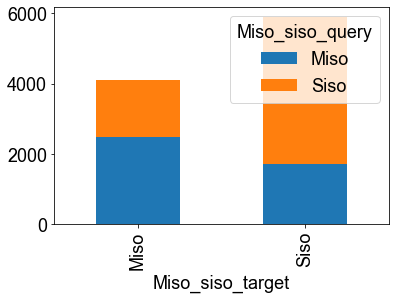

In [330]:
paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count').reset_index().pivot(columns=['Miso_siso_query'], index='Miso_siso_target', values='count').plot.bar(stacked=True)

In [539]:
paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count').reset_index().pivot(columns=['Miso_siso_query'], index='Miso_siso_target', values='count')

Miso_siso_query,Miso,Siso
Miso_siso_target,,
Miso,2484,1632
Siso,1720,4172


[[2391, 1352], [2000, 4172]]
[4391, 5524, 4391, 5524]
Rectangle(xy=(-0.25, 0), width=0.5, height=2391, angle=0) 2391 [4391, 5524, 4391, 5524] 0.5445228877248918
Rectangle(xy=(0.75, 0), width=0.5, height=1352, angle=0) 1352 [4391, 5524, 4391, 5524] 0.2447501810282404
Rectangle(xy=(-0.25, 2391), width=0.5, height=2000, angle=0) 2000 [4391, 5524, 4391, 5524] 0.4554771122751082
Rectangle(xy=(0.75, 1352), width=0.5, height=4172, angle=0) 4172 [4391, 5524, 4391, 5524] 0.7552498189717596


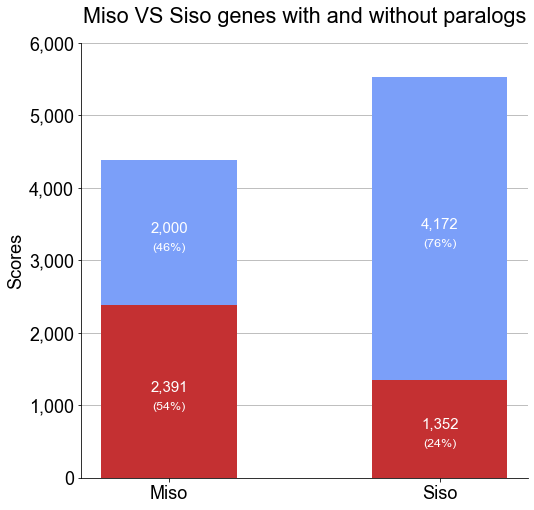

In [174]:

fig, ax = plt.subplots(figsize=(8,8))



data = paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count').reset_index().pivot(columns=['Miso_siso_query'], index='Miso_siso_target', values='count')



labels = concat.index.tolist()
men_means = data['Miso'].values.tolist()
women_means = data['Siso'].values.tolist()
width = 0.5       # the width of the bars: can also be len(x) sequence


palette_para = {
    "Miso_para" : palette['Miso'],
    "Siso_para" : palette['Siso'],
    "Miso_not_para" : '#F39B7FFF',
    "Siso_not_para" : '#91D1C2FF',
}


ax.bar(labels, men_means, width, label='With paralogs', color=[palette_para['Miso_para'], palette_para['Miso_para']], )
ax.bar(labels, women_means, width, bottom=men_means, label='Without paralogs', color=[palette_para['Siso_para'], palette_para['Siso_para']])
ax.set_ylim(0,6e3)
ax.set_ylabel('Scores')
ax.set_title('Miso VS Siso genes with and without paralogs', pad=20)

circ1 = mpatches.Patch( facecolor='white', hatch="//", edgecolor='black', label="With paralogs")
circ2= mpatches.Patch( facecolor='white', edgecolor='black', label='Without paralogs')
# ax.legend(handles=[circ1, circ2], loc='upper left')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
ax.set_axisbelow(True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis='y')
show_values_on_bars(ax, padding=250)

In [556]:
[sub_e for e in data.values.tolist() for sub_e in e]

[2484, 1632, 1720, 4172]

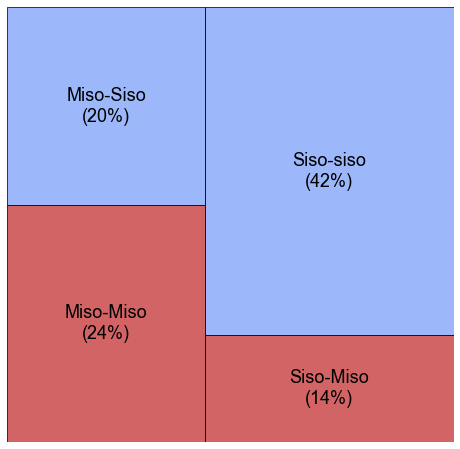

In [175]:
#libraries
# import matplotlib.pyplot as plt
 
data = paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count').reset_index().pivot(columns=['Miso_siso_query'], index='Miso_siso_target', values='count')



labels = concat.index.tolist()
men_means = data['Miso'].values.tolist()
women_means = data['Siso'].values.tolist()
width = 0.5       # the width of the bars: can also be len(x) sequence


palette_para = {
    "Miso_para" : palette['Miso'],
    "Siso_para" : palette['Siso'],
    "Miso_not_para" : '#F39B7FFF',
    "Siso_not_para" : '#91D1C2FF',
}
    
values = [sub_e for e in data.values.tolist() for sub_e in e]
labels = ["Miso-Miso" , 'Miso-Siso' , 'Siso-Miso', 'Siso-siso']
labels = ["{}\n({}%)".format(e,int(100*round(j/sum(values),2))) for e,j in zip(labels, values)]
    
f, ax= plt.subplots(figsize=(8,8))
    
# Change color
squarify.plot(sizes=values, 
              label=labels, 
              color=[palette['Miso'], palette['Siso'], palette['Miso'], palette['Siso']], alpha=.75, edgecolor='black', ax=ax)
plt.axis('off')
plt.show()

['Miso', 'Siso']
[3743, 6172]
['Miso', 'Siso', 'Siso', 'Miso']
[2391, 1352, 4172, 2000]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  antialiased or aa: unknown
  capstyle: {'butt', 'round', 'projecting'}
  center: unknown
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color: color
  contains: callable
  edgecolor or ec: color or None or 'auto'
  facecolor or fc: color or None
  figure: `.Figure`
  fill: bool
  gid: str
  hatch: {'/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
  in_layout: bool
  joinstyle: {'miter', 'round', 'bevel'}
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float or None
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  radius: unknown
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomnes

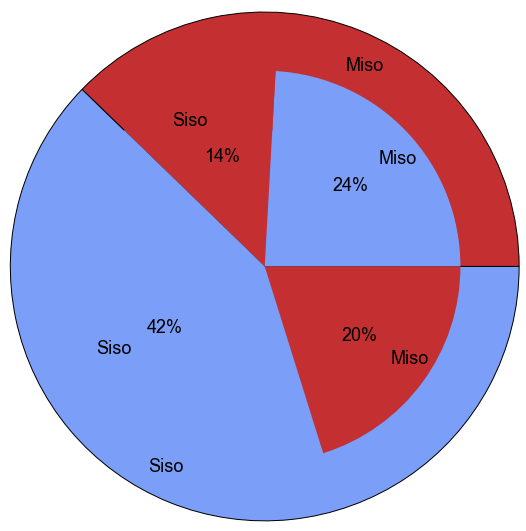

In [176]:
data_pie = paralogs_count_by_cat.groupby(['Miso_siso_query'])['Miso_siso_target'].value_counts().rename('count').reset_index()

# Make data: I have 3 groups and 7 subgroups
group_names=data_pie.Miso_siso_query.unique().tolist()
group_size=data_pie.groupby('Miso_siso_query')['count'].sum().values.tolist()
print(group_names)
print(group_size)
subgroup_names=data_pie['Miso_siso_target'].values.tolist()
subgroup_size=data_pie['count'].values.tolist()
print(subgroup_names)
print(subgroup_size)
 
f, ax = plt.subplots(figsize=(9,9)) 

plt.rcParams.update({'font.size' : 18, 'figure.facecolor' : 'white'})
    
# Create colors
a, b, =[plt.cm.Blues, plt.cm.Reds]
 
# First Ring (outside)
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, labeldistance=0.85, colors=[palette['Miso'], palette['Siso']])
plt.setp( mypie, width=2, edgecolor='black', )
 
# Second Ring (Inside)
mypie2 = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names,  autopct='%1.0f%%', pctdistance=0.6, labeldistance=0.8, 
                colors=[palette['Siso'], palette['Miso'], palette['Siso'], palette['Miso']])
plt.setp(mypie2)
plt.margins(0,0)
 
# show it
plt.show()

In [34]:
paralogs_count_by_cat_boxplot = paralogs_count_by_cat.groupby(['Miso_siso_query', 'Gene'])['Miso_siso_target'].value_counts().rename('count').reset_index()
paralogs_count_by_cat_boxplot

,Miso_siso_query,Gene,Miso_siso_target,count
0,Miso,A4GALT,Siso,1
1,Miso,ABCD4,Miso,1
2,Miso,ABCD4,Siso,1
3,Miso,ABHD2,Siso,1
4,Miso,ABHD3,Siso,2
...,...,...,...,...
5105,Siso,ZNF98,Siso,3
5106,Siso,ZNF99,Siso,1
5107,Siso,ZRSR2,Miso,2
5108,Siso,ZSWIM1,Siso,1


In [348]:
paralogs_count_by_cat_boxplot.sort_values(by='Miso_siso_query', ascending=True)

,Miso_siso_query,Gene,Miso_siso_target,count
0,Miso,A4GALT,Siso,1
1735,Miso,PSG5,Miso,11
1736,Miso,PSG5,Siso,4
1737,Miso,PSG6,Miso,8
1738,Miso,PSG6,Siso,3
...,...,...,...,...
3443,Siso,H2AC6,Siso,2
3444,Siso,H2AC8,Siso,3
3445,Siso,H2AJ,Siso,2
3438,Siso,H2AC16,Siso,5


In [400]:
paralogs_count_by_cat_boxplot.sort_values(by=['Miso_siso_query', 'Miso_siso_target'], ascending=True).groupby(['Miso_siso_query', 'Miso_siso_target']).describe()

count                                     \
                                   count      mean       std  min  25%  50%   
Miso_siso_query Miso_siso_target                                              
Miso            Miso              1548.0  1.604651  1.222512  1.0  1.0  1.0   
                Siso              1061.0  1.621112  1.662485  1.0  1.0  1.0   
Siso            Miso              1014.0  1.609467  1.156700  1.0  1.0  1.0   
                Siso              1487.0  2.805649  3.098955  1.0  1.0  2.0   

                                             
                                  75%   max  
Miso_siso_query Miso_siso_target             
Miso            Miso              2.0  14.0  
                Siso              2.0  19.0  
Siso            Miso              2.0  15.0  
                Siso              3.0  24.0

In [573]:
paralogs_count_by_cat_boxplot

,Miso_siso_query,Gene,Miso_siso_target,count
0,Miso,A4GALT,Siso,1
1,Miso,ABCD4,Miso,1
2,Miso,ABCD4,Siso,1
3,Miso,ABHD2,Siso,1
4,Miso,ABHD3,Siso,2
...,...,...,...,...
5105,Siso,ZNF98,Siso,3
5106,Siso,ZNF99,Siso,1
5107,Siso,ZRSR2,Miso,2
5108,Siso,ZSWIM1,Siso,1


Miso_siso_query
Miso    1
Siso    1
Name: count, dtype: int64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Siso_Miso v.s. Siso_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.498e-23 U_stat=5.944e+05
Miso_Miso v.s. Miso_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.933e-02 U_stat=8.540e+05


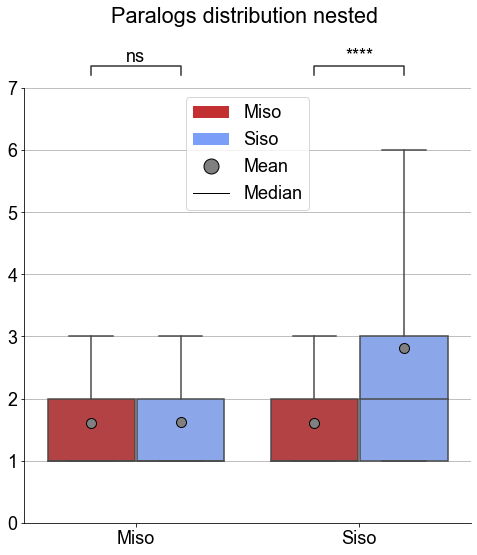

In [35]:

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False):

    if x:
        data = data.sort_values(by=x,ascending=True)
        sns.boxplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, palette=palette, showmeans=True, meanline=False, 
                    meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
    else:
        sns.boxplot(data=data, y=y, showfliers=False, ax=ax, palette=palette)
        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x: 
        ax.spines['bottom'].set_linewidth(0)

        ax.axes.xaxis.set_visible(False)
    ax.set_axisbelow(True)

    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [  
                    mpatches.Patch( facecolor=palette['Miso']),
                    mpatches.Patch( facecolor=palette['Siso']),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
                    matplotlib.lines.Line2D([0], [0], color='black', lw=1)
                    ],  
              labels= ["Miso", "Siso", 'Mean', "Median"], title='', ncol=1, loc='upper center')
    else:
        ax.legend().remove()

    if x: 
        medians = data.groupby(x)[y].median()
        vertical_offset = data[y].median() * 0.15 # offset from median for display

        for xtick in ax.get_xticks():
            ax.text(xtick,medians[xtick] - padding_value_boxplot,round(medians[xtick],2), 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
    else:
        medians = data[y].median()
        vertical_offset = data[y].median() * 0.15 # offset from median for display
        for xtick in ax.get_xticks():
            ax.text(xtick,medians - padding_value_boxplot,medians, 
                    horizontalalignment='center',size='small',color='w',weight='semibold')
    print(medians)


    
#     ax.spines['right'].set_linewidth(0)

    if x: 
        add_stat_annotation(ax, data=data, x=x, y=y,hue=hue, box_pairs=box_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='outside', verbose=2)
    return ax



f, ax = plt.subplots(figsize=(8,8))

data_paralogs_count_boxplot = paralogs_count_by_cat_boxplot.sort_values(by=['Miso_siso_query', 'Miso_siso_target'], ascending=True)

custom_boxplot(data_paralogs_count_boxplot,"Miso_siso_query","count",'Miso_siso_target',ax,(0,7),"Paralogs distribution nested ",
               [
                   (("Miso", "Miso"), ("Miso", "Siso")), 
                   (("Siso", "Siso"), ("Siso", "Miso")),
#                    (("Miso", "Siso"), ("Siso", "Miso")),
#                    (("Miso", "Miso"), ("Siso", "Miso")),
#                    (("Miso", "Siso"), ("Siso", "Siso")),
                   
               ], palette=palette, padding_title=65, padding_value_boxplot=0.75, legend=True)

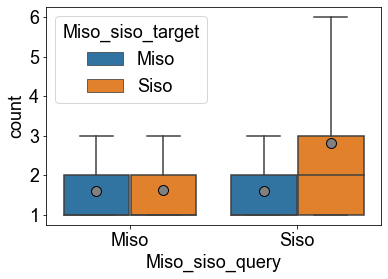

In [406]:
sns.boxplot(data=paralogs_count_by_cat_boxplot.sort_values(by=['Miso_siso_query', 'Miso_siso_target'], ascending=True), x='Miso_siso_query', y='count', hue='Miso_siso_target', showfliers=False, 
             showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})

In [ ]:
paralogs_introns = pd.merge(paralogs.rename({'Gene name':'Gene'},axis=1), refseq_introns[['Gene', 'Miso_siso', 'Introns_ranges']], on='Gene')
paralogs_introns['Introns_nb'] = paralogs_introns['Introns_ranges']



# Gene families

In [12]:
hgnc = pd.read_csv('/gstock/EXOTIC/data/HGNC/gene_with_protein_product.txt', sep='\t')
hgnc.columns
# hgnc

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (31,38,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status',
       'location', 'location_sortable', 'alias_symbol', 'alias_name',
       'prev_symbol', 'prev_name', 'gene_family', 'gene_family_id',
       'date_approved_reserved', 'date_symbol_changed', 'date_name_changed',
       'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id',
       'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id',
       'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb',
       'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org',
       'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog',
       'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id',
       'intermediate_filament_db', 'rna_central_ids', 'lncipedia', 'gtrnadb',
       'agr', 'mane_select'],
      dtype='object')

In [742]:
hgnc.loc[hgnc['gene_family'].isna() == True].shape

(5025, 53)

In [13]:
hgnc_lite = hgnc[['hgnc_id', 'symbol', 'name' , 'gene_family', 'gene_family_id']]
hgnc_lite['gene_family'] = hgnc_lite['gene_family'].str.split('|')
hgnc_lite = hgnc_lite.explode('gene_family')
hgnc_lite

,hgnc_id,symbol,name,gene_family,gene_family_id
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Immunoglobulin like domain containing,594
1,HGNC:24086,A1CF,APOBEC1 complementation factor,RNA binding motif containing,725
2,HGNC:7,A2M,alpha-2-macroglobulin,"C3 and PZP like, alpha-2-macroglobulin domain ...",1234
3,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,"C3 and PZP like, alpha-2-macroglobulin domain ...",1234
4,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",Glycosyltransferase family 6,429
...,...,...,...,...,...
19193,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Zinc fingers ZZ-type,91|863
19193,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,EF-hand domain containing,91|863
19194,HGNC:24523,ZZZ3,zinc finger ZZ-type containing 3,Zinc fingers ZZ-type,91|532|1058
19194,HGNC:24523,ZZZ3,zinc finger ZZ-type containing 3,Myb/SANT domain containing,91|532|1058


In [21]:
hgnc_lite_dropna.loc[hgnc_lite_dropna['gene_family'].str.contains('GPCR')]

1813    C3AR1
1845    C5AR1
1846    C5AR2
Name: symbol, dtype: object

In [586]:
hgnc_lite.symbol.nunique()

19195

In [17]:
hgnc_lite_dropna = hgnc_lite.dropna(subset=['gene_family'])
hgnc_lite_dropna.loc[hgnc_lite_dropna['gene_family'].str.contains('Olfactory')].gene_family.value_counts()

Olfactory receptors, family 2     68
Olfactory receptors, family 4     57
Olfactory receptors, family 5     50
Olfactory receptors, family 10    38
Olfactory receptors, family 6     30
Olfactory receptors, family 1     29
Olfactory receptors, family 52    27
Olfactory receptors, family 51    24
Olfactory receptors, family 8     24
Olfactory receptors, family 13    13
Olfactory receptors, family 7     11
Olfactory receptors, family 11     9
Olfactory receptors, family 9      8
Olfactory receptors, family 14     6
Olfactory receptors, family 56     6
Olfactory receptors, family 12     3
Olfactory receptors, family 3      3
Name: gene_family, dtype: int64

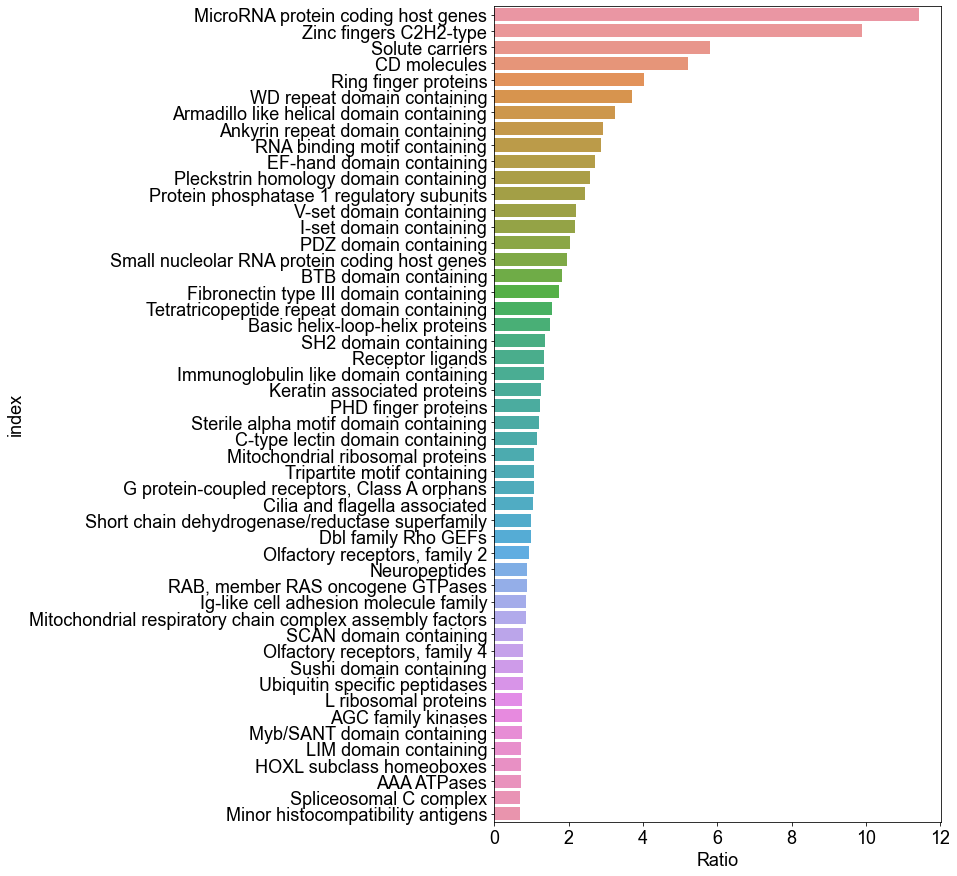

In [44]:
count_test = hgnc_lite.gene_family.value_counts().rename('count').reset_index()
count_test = count_test.loc[count_test['count'] > 50]
count_test['Ratio'] = 100 * (count_test['count'] / count_test['count'].sum())
f, ax = plt.subplots(figsize=(8,15))

sns.barplot(data=count_test, y='index', x='Ratio')

# plt.xticks(rotation=90)

In [14]:
hgnc_miso_siso = pd.merge(genes[['Gene', 'Miso_siso']], hgnc_lite.rename({'symbol' : 'Gene'}, axis=1), on ='Gene')
hgnc_miso_siso.dropna(subset=['gene_family'])['Miso_siso'].value_counts()
miso_siso_nb = hgnc_miso_siso.dropna(subset=['gene_family'])['Miso_siso'].value_counts()
fract_miso = miso_siso_nb['Miso'] / miso_siso_nb.sum()
fract_siso = miso_siso_nb['Siso'] / miso_siso_nb.sum()

KeyError: "['Miso_siso'] not in index"

In [8]:
hgnc_miso_siso = pd.merge(genes[['Gene', 'Miso_siso']], hgnc_lite.rename({'symbol' : 'Gene'}, axis=1), on ='Gene')
count = hgnc_miso_siso.groupby('gene_family')['Miso_siso'].value_counts().rename('count').reset_index()
# count = count.loc[count['gene_family'].isin(count_test['index'].tolist())]
count

# f, ax = plt.subplots(figsize=(8,30))

# sns.barplot(data=count, y='gene_family', hue='Miso_siso', x='count', palette=palette)

# plt.xticks(rotation=90)

,gene_family,Miso_siso,count
0,Mitochondrial translation release factor family,Miso,3
1,1-acylglycerol-3-phosphate O-acyltransferases,Miso,6
2,1-acylglycerol-3-phosphate O-acyltransferases,Siso,5
3,14-3-3 phospho-serine/phospho-threonine bindin...,Siso,5
4,14-3-3 phospho-serine/phospho-threonine bindin...,Miso,2
...,...,...,...
2374,tRNA splicing ligase complex,Miso,3
2375,tRNA-splicing endonuclease subunits,Miso,3
2376,tRNA-splicing endonuclease subunits,Siso,1
2377,tri-snRP complex,Miso,2


In [1]:
hgnc_miso_siso

NameError: name 'hgnc_miso_siso' is not defined

In [537]:
count_stat_siso = count.pivot(index='gene_family', columns='Miso_siso', values='count')
count_stat_siso = count_stat_siso.fillna(0)
count_stat_siso['Total'] = count_stat_siso.apply(sum, axis=1)
count_stat_siso['binom_test'] = count_stat_siso.progress_apply(lambda r: scipy.stats.binom_test(x=r['Siso'], n=r['Total'], p=fract_siso, alternative='greater'), axis=1)
rej, padj = fdrcorrection(count_stat_siso.binom_test.values)
count_stat_siso['Rejected'] = rej
count_stat_siso['Padj'] = padj
count_stat_siso = count_stat_siso.loc[count_stat_siso['Padj']< 0.05]
count_stat_siso['Diff'] = count_stat_siso['Siso'] - count_stat_siso['Miso']
count_stat_siso = count_stat_siso.sort_values(by='gene_family', ascending=False)
count_stat_siso

100%|██████████| 1325/1325 [00:00<00:00, 3381.92it/s]


Miso_siso,Miso,Siso,Total,binom_test,Rejected,Padj,Diff
gene_family,,,,,,,
Zinc fingers 3CxxC-type,0.0,8.0,8.0,1.268915e-03,True,3.655027e-02,8.0
Taste 2 receptors,0.0,24.0,24.0,2.043138e-09,True,2.461053e-07,24.0
"Sulfotransferases, membrane bound",9.0,25.0,34.0,3.693598e-04,True,1.322707e-02,16.0
Speedy/RINGO cell cycle regulator family,1.0,10.0,11.0,1.593964e-03,True,4.400004e-02,9.0
Small proline rich proteins,0.0,8.0,8.0,1.268915e-03,True,3.655027e-02,8.0
Secretoglobins,0.0,10.0,10.0,2.394918e-04,True,9.333138e-03,10.0
SRY-box transcription factors,3.0,17.0,20.0,1.642764e-04,True,7.021489e-03,14.0
SPANX family,0.0,9.0,9.0,5.512666e-04,True,1.872893e-02,9.0
S100 calcium binding proteins,2.0,15.0,17.0,1.774057e-04,True,7.345706e-03,13.0


In [581]:
count

,gene_family,Miso_siso,count
0,Mitochondrial translation release factor family,Miso,2
1,1-acylglycerol-3-phosphate O-acyltransferases,Miso,5
2,1-acylglycerol-3-phosphate O-acyltransferases,Siso,5
3,14-3-3 phospho-serine/phospho-threonine bindin...,Siso,5
4,3-hydroxyacyl-CoA dehydratase family,Miso,2
...,...,...,...
2328,tRNA splicing ligase complex,Miso,3
2329,tRNA-splicing endonuclease subunits,Miso,3
2330,tRNA-splicing endonuclease subunits,Siso,1
2331,tri-snRP complex,Miso,2


In [87]:
print(hgnc_miso_siso.loc[(hgnc_miso_siso['gene_family'].isin(count_stat_miso.index.tolist())) & (hgnc_miso_siso['Miso_siso'] == 'Miso')]['Gene'].values.tolist())

['PLEKHN1', 'INTS11', 'DVL1', 'PRDM16', 'PRDM16', 'SMIM1', 'PLEKHG5', 'ZBTB48', 'ENO1', 'NMNAT1', 'KIF1B', 'KIF1B', 'CASZ1', 'DHRS3', 'FBLIM1', 'ZBTB17', 'ALDH4A1', 'EIF4G3', 'ZBTB40', 'EPHB2', 'KDM1A', 'HNRNPR', 'ZNF436', 'RUNX3', 'RHD', 'RHCE', 'STMN1', 'CNKSR1', 'ZNF683', 'RPS6KA1', 'ADGRB2', 'TMEM39B', 'ZBTB8A', 'ZNF362', 'PHC2', 'ZC3H12A', 'MEAF6', 'FHL3', 'ZFP69B', 'ZFP69B', 'ZFP69', 'ZFP69', 'NFYC', 'HIVEP3', 'ERMAP', 'ZNF691', 'EBNA1BP2', 'ELOVL1', 'SZT2', 'ST3GAL3', 'RNF220', 'OSBPL9', 'NRDC', 'SCP2', 'GLIS1', 'PATJ', 'CACHD1', 'SGIP1', 'WLS', 'ZRANB2', 'ST6GALNAC5', 'ODF2L', 'LMO4', 'ZNF326', 'ZNF644', 'GFI1', 'MTF2', 'PTBP2', 'RTCA', 'VCAM1', 'VAV3', 'VAV3', 'TRIM33', 'CD58', 'CD58', 'CD2', 'PLEKHO1', 'TARS2', 'ADAMTSL4', 'ZNF687', 'TUFT1', 'SLC39A1', 'NUP210L', 'ZBTB7B', 'ASH1L', 'ASH1L', 'ARHGEF2', 'ARHGEF2', 'ARHGEF11', 'ACKR1', 'SLAMF6', 'CD84', 'SLAMF1', 'CD244', 'F11R', 'TOMM40L', 'MPZ', 'NOS1AP', 'UCK2', 'FAM78B', 'DCAF6', 'FMO3', 'DNM3', 'DNM3', 'ZBTB37', 'ASTN1', 'R

In [43]:
print(hgnc_miso_siso.loc[(hgnc_miso_siso['gene_family'].isin(count_stat_siso.index.tolist())) & (hgnc_miso_siso['Miso_siso'] == 'Siso')]['Gene'].values.tolist())

['OR4F5', 'OR4F29', 'OR4F16', 'MMP23B', 'HES5', 'HES3', 'GPR153', 'HES2', 'PRAMEF12', 'PRAMEF11', 'PRAMEF2', 'PRAMEF4', 'PRAMEF10', 'PRAMEF7', 'PRAMEF6', 'PRAMEF18', 'PRAMEF25', 'PRAMEF5', 'PRAMEF13', 'PRAMEF8', 'PRAMEF15', 'PRAMEF14', 'PRAMEF19', 'PRAMEF17', 'PRAMEF20', 'ID3', 'GPR3', 'GJB5', 'GJB4', 'GJA4', 'GJA9', 'HEYL', 'FOXO6', 'FOXE3', 'FOXD2', 'FOXD3', 'BARHL2', 'GPR88', 'GPR61', 'GJA8', 'H3-2', 'H3C13', 'H4C14', 'H3C14', 'H2AC18', 'H2AC19', 'H3C15', 'H4C15', 'H2BC21', 'H2AC20', 'H2AC21', 'LCE5A', 'LCE3E', 'LCE3D', 'LCE3C', 'LCE3B', 'LCE3A', 'LCE2D', 'LCE2C', 'LCE2B', 'LCE2A', 'LCE4A', 'LCE1F', 'LCE1E', 'LCE1D', 'LCE1B', 'LCE1A', 'LCE6A', 'OR10T2', 'OR10K2', 'OR10K1', 'OR10R2', 'OR6Y1', 'OR6P1', 'OR10X1', 'OR10Z1', 'OR6K2', 'OR6K3', 'OR6K6', 'OR6N1', 'OR6N2', 'OR10J3', 'OR10J4', 'OR10J5', 'NHLH1', 'XCL2', 'XCL1', 'GPR52', 'GPR25', 'ASCL5', 'GPR37L1', 'MYOG', 'SOX13', 'HLX', 'H3-3A', 'GJC2', 'H3-4', 'H2AW', 'H2BU1', 'OR2B11', 'OR2C3', 'OR2G2', 'OR2G3', 'OR13G1', 'OR6F1', 'OR1C1'

In [552]:
count_stat_siso = count_stat_siso.reset_index()
count_stat_siso['Label'] = count_stat_siso['gene_family'] + ' (' + count_stat_siso['Total'].astype(int).astype(str) + ')'
count_stat_siso = count_stat_siso.set_index('gene_family')
count_stat_siso

Miso_siso,Miso,Siso,Total,binom_test,Rejected,Padj,Diff,Label
gene_family,,,,,,,,
Zinc fingers 3CxxC-type,0.0,8.0,8.0,1.268915e-03,True,3.655027e-02,8.0,Zinc fingers 3CxxC-type (8)
Taste 2 receptors,0.0,24.0,24.0,2.043138e-09,True,2.461053e-07,24.0,Taste 2 receptors (24)
"Sulfotransferases, membrane bound",9.0,25.0,34.0,3.693598e-04,True,1.322707e-02,16.0,"Sulfotransferases, membrane bound (34)"
Speedy/RINGO cell cycle regulator family,1.0,10.0,11.0,1.593964e-03,True,4.400004e-02,9.0,Speedy/RINGO cell cycle regulator family (11)
Small proline rich proteins,0.0,8.0,8.0,1.268915e-03,True,3.655027e-02,8.0,Small proline rich proteins (8)
Secretoglobins,0.0,10.0,10.0,2.394918e-04,True,9.333138e-03,10.0,Secretoglobins (10)
SRY-box transcription factors,3.0,17.0,20.0,1.642764e-04,True,7.021489e-03,14.0,SRY-box transcription factors (20)
SPANX family,0.0,9.0,9.0,5.512666e-04,True,1.872893e-02,9.0,SPANX family (9)
S100 calcium binding proteins,2.0,15.0,17.0,1.774057e-04,True,7.345706e-03,13.0,S100 calcium binding proteins (17)


In [42]:
count_stat_miso.shape

(9, 8)

100%|██████████| 1333/1333 [00:00<00:00, 3379.23it/s]


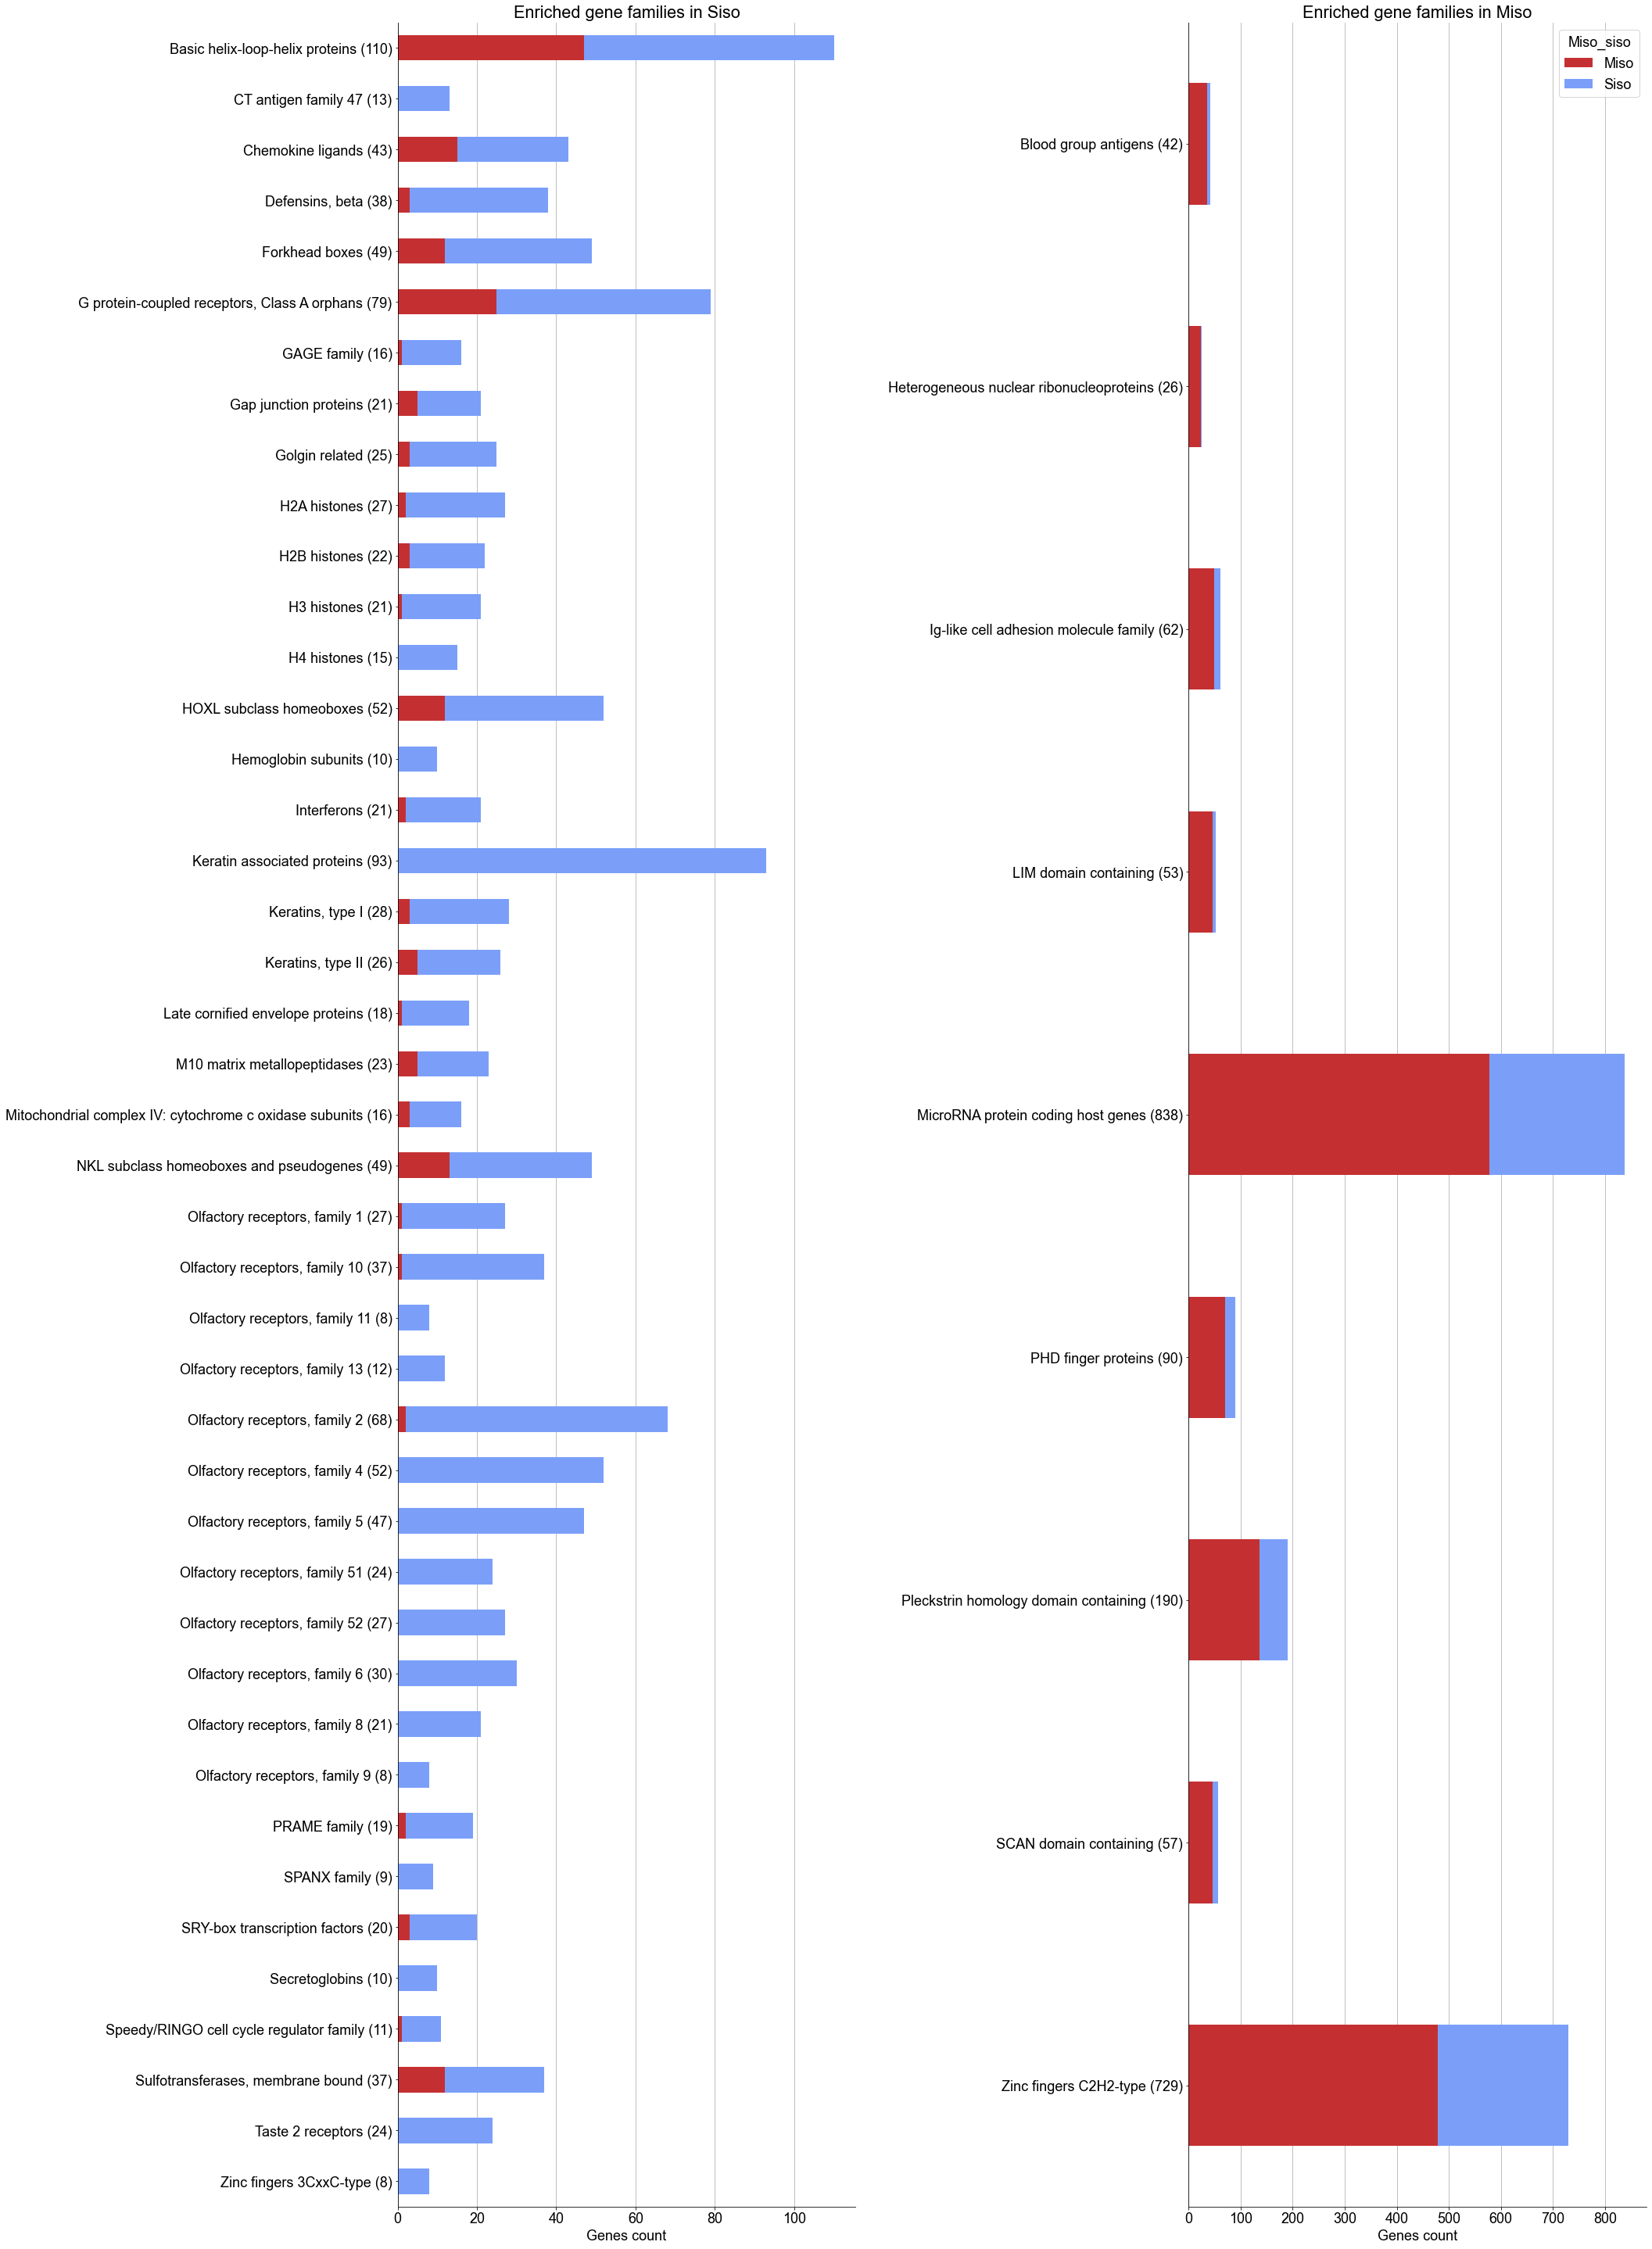

In [40]:
from statsmodels.stats.multitest import fdrcorrection

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }


f, ax = plt.subplots(ncols=2, figsize=(30, 40))




count_stat_siso = count.pivot(index='gene_family', columns='Miso_siso', values='count')
count_stat_siso = count_stat_siso.fillna(0)
count_stat_siso['Total'] = count_stat_siso.apply(sum, axis=1)
count_stat_siso['binom_test'] = count_stat_siso.progress_apply(lambda r: scipy.stats.binom_test(x=r['Siso'], n=r['Total'], p=fract_siso, alternative='greater'), axis=1)
rej, padj = fdrcorrection(count_stat_siso.binom_test.values)
count_stat_siso['Rejected'] = rej
count_stat_siso['Padj'] = padj
count_stat_siso = count_stat_siso.loc[count_stat_siso['Padj']< 0.05]
count_stat_siso['Diff'] = count_stat_siso['Siso'] - count_stat_siso['Miso']
count_stat_siso = count_stat_siso.sort_values(by='gene_family', ascending=False)

count_stat_siso = count_stat_siso.reset_index()
count_stat_siso['Label'] = count_stat_siso['gene_family'] + ' (' + count_stat_siso['Total'].astype(int).astype(str) + ')'
count_stat_siso = count_stat_siso.set_index('gene_family')
count_stat_siso

count_stat_siso[['Miso', 'Siso']].plot(kind='barh', stacked=True, ax=ax[0], color=[palette['Miso'], palette['Siso']])
ax[0].legend().remove()
ax[0].set_title('Enriched gene families in Siso')
ax[0].set_yticklabels(count_stat_siso.Label.values.tolist())

count_stat_miso = count.pivot(index='gene_family', columns='Miso_siso', values='count')
count_stat_miso = count_stat_miso.fillna(0)
count_stat_miso['Total'] = count_stat_miso.apply(sum, axis=1)
count_stat_miso['binom_test'] = count_stat_miso.progress_apply(lambda r: scipy.stats.binom_test(x=r['Miso'], n=r['Total'], p=fract_miso, alternative='greater'), axis=1)
rej, padj = fdrcorrection(count_stat_miso.binom_test.values)
count_stat_miso['Rejected'] = rej
count_stat_miso['Padj'] = padj
count_stat_miso = count_stat_miso.loc[count_stat_miso['Padj']< 0.05]
count_stat_miso['Diff'] = count_stat_miso['Siso'] - count_stat_miso['Miso']
count_stat_miso = count_stat_miso.sort_values(by='gene_family', ascending=False)

count_stat_miso = count_stat_miso.reset_index()
count_stat_miso ['Label'] = count_stat_miso['gene_family'] + ' (' + count_stat_miso['Total'].astype(int).astype(str) + ')'
count_stat_miso = count_stat_miso.set_index('gene_family')
count_stat_miso

count_stat_miso[['Miso', 'Siso']].plot(kind='barh', stacked=True, ax=ax[1], color=[palette['Miso'], palette['Siso']])

ax[1].set_title('Enriched gene families in Miso')
ax[1].set_yticklabels(count_stat_miso.Label.values.tolist())

plt.tight_layout()

for sub_ax in ax:
    sub_ax.spines['right'].set_linewidth(0)
    sub_ax.spines['top'].set_linewidth(0)
    sub_ax.set_ylabel('')
    sub_ax.grid(axis='x')
    sub_ax.set_axisbelow(True)
    sub_ax.set_xlabel('Genes count')

# # plt.xticks(rotation=90)

In [187]:
print(count_stat_siso.Siso.sum())
count_stat_siso.Total.describe()

1955.0


count    120.000000
mean      20.016667
std       19.410204
min        4.000000
25%        8.000000
50%       12.500000
75%       24.000000
max      105.000000
Name: Total, dtype: float64

In [63]:
hgnc_siso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_siso.index.tolist())]
hgnc_siso_enriched

,Gene,Miso_siso,hgnc_id,name,gene_family,gene_family_id
0,OR4F5,Siso,HGNC:14825,olfactory receptor family 4 subfamily F member 5,"Olfactory receptors, family 4",151
1,OR4F29,Siso,HGNC:31275,olfactory receptor family 4 subfamily F member 29,"Olfactory receptors, family 4",151
2,OR4F16,Siso,HGNC:15079,olfactory receptor family 4 subfamily F member 16,"Olfactory receptors, family 4",151
10,HES4,Miso,HGNC:24149,hes family bHLH transcription factor 4,Basic helix-loop-helix proteins,420
21,B3GALT6,Siso,HGNC:17978,"beta-1,3-galactosyltransferase 6",Beta 3-glycosyltransferases,426
...,...,...,...,...,...,...
22097,SRY,Siso,HGNC:11311,sex determining region Y,SRY-box transcription factors,757
22098,RPS4Y1,Siso,HGNC:10425,ribosomal protein S4 Y-linked 1,S ribosomal proteins,728|870
22119,VCY,Siso,HGNC:12668,variable charge Y-linked,Variable charge X/Y family,368
22120,VCY1B,Siso,HGNC:31751,variable charge Y-linked 1B,Variable charge X/Y family,368


In [125]:
count

,gene_family,Miso_siso,count
0,Mitochondrial translation release factor family,Miso,2
1,1-acylglycerol-3-phosphate O-acyltransferases,Miso,5
2,1-acylglycerol-3-phosphate O-acyltransferases,Siso,5
3,14-3-3 phospho-serine/phospho-threonine bindin...,Siso,5
4,3-hydroxyacyl-CoA dehydratase family,Miso,2
...,...,...,...
2328,tRNA splicing ligase complex,Miso,3
2329,tRNA-splicing endonuclease subunits,Miso,3
2330,tRNA-splicing endonuclease subunits,Siso,1
2331,tri-snRP complex,Miso,2


In [115]:
stats_all_families_siso

,gene_family,Total
0,1-acylglycerol-3-phosphate O-acyltransferases,5
1,14-3-3 phospho-serine/phospho-threonine bindin...,5
2,3-hydroxyacyl-CoA dehydratase family,2
3,5'-nucleotidases,2
4,"5-hydroxytryptamine receptors, G protein-coupled",6
...,...,...
1122,minichromosome maintenance 2-7 complex,3
1123,p120 catenin family,1
1124,tRNA splicing ligase complex,4
1125,tRNA-splicing endonuclease subunits,1


In [123]:
hgnc_miso_siso.loc[hgnc_miso_siso['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()

,gene_family,Total
0,1-acylglycerol-3-phosphate O-acyltransferases,5
1,14-3-3 phospho-serine/phospho-threonine bindin...,5
2,3-hydroxyacyl-CoA dehydratase family,2
3,5'-nucleotidases,2
4,"5-hydroxytryptamine receptors, G protein-coupled",6
...,...,...
1122,minichromosome maintenance 2-7 complex,3
1123,p120 catenin family,1
1124,tRNA splicing ligase complex,4
1125,tRNA-splicing endonuclease subunits,1


In [135]:
hgnc_siso_enriched.Gene.nunique()

2347

In [146]:
hgnc_siso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_siso.index.tolist())]

paralogs_siso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_siso_enriched.Gene.values.tolist())]
paralogs_siso_enriched = paralogs_siso_enriched.loc[paralogs_siso_enriched['Miso_siso'] == 'Siso'].drop_duplicates(subset=['Gene'])
paralogs_siso_enriched = pd.merge(paralogs_siso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_siso_enriched = paralogs_siso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_siso_enriched_count = hgnc_siso_enriched.loc[hgnc_siso_enriched['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()

,Ratio
gene_family,
Blood group antigens,44.444444
Heterogeneous nuclear ribonucleoproteins,45.833333
Ig-like cell adhesion molecule family,32.000000
LIM domain containing,34.782609
MicroRNA protein coding host genes,28.719723
PHD finger proteins,18.309859
Pleckstrin homology domain containing,25.000000
SCAN domain containing,6.382979
Zinc fingers C2H2-type,25.469729


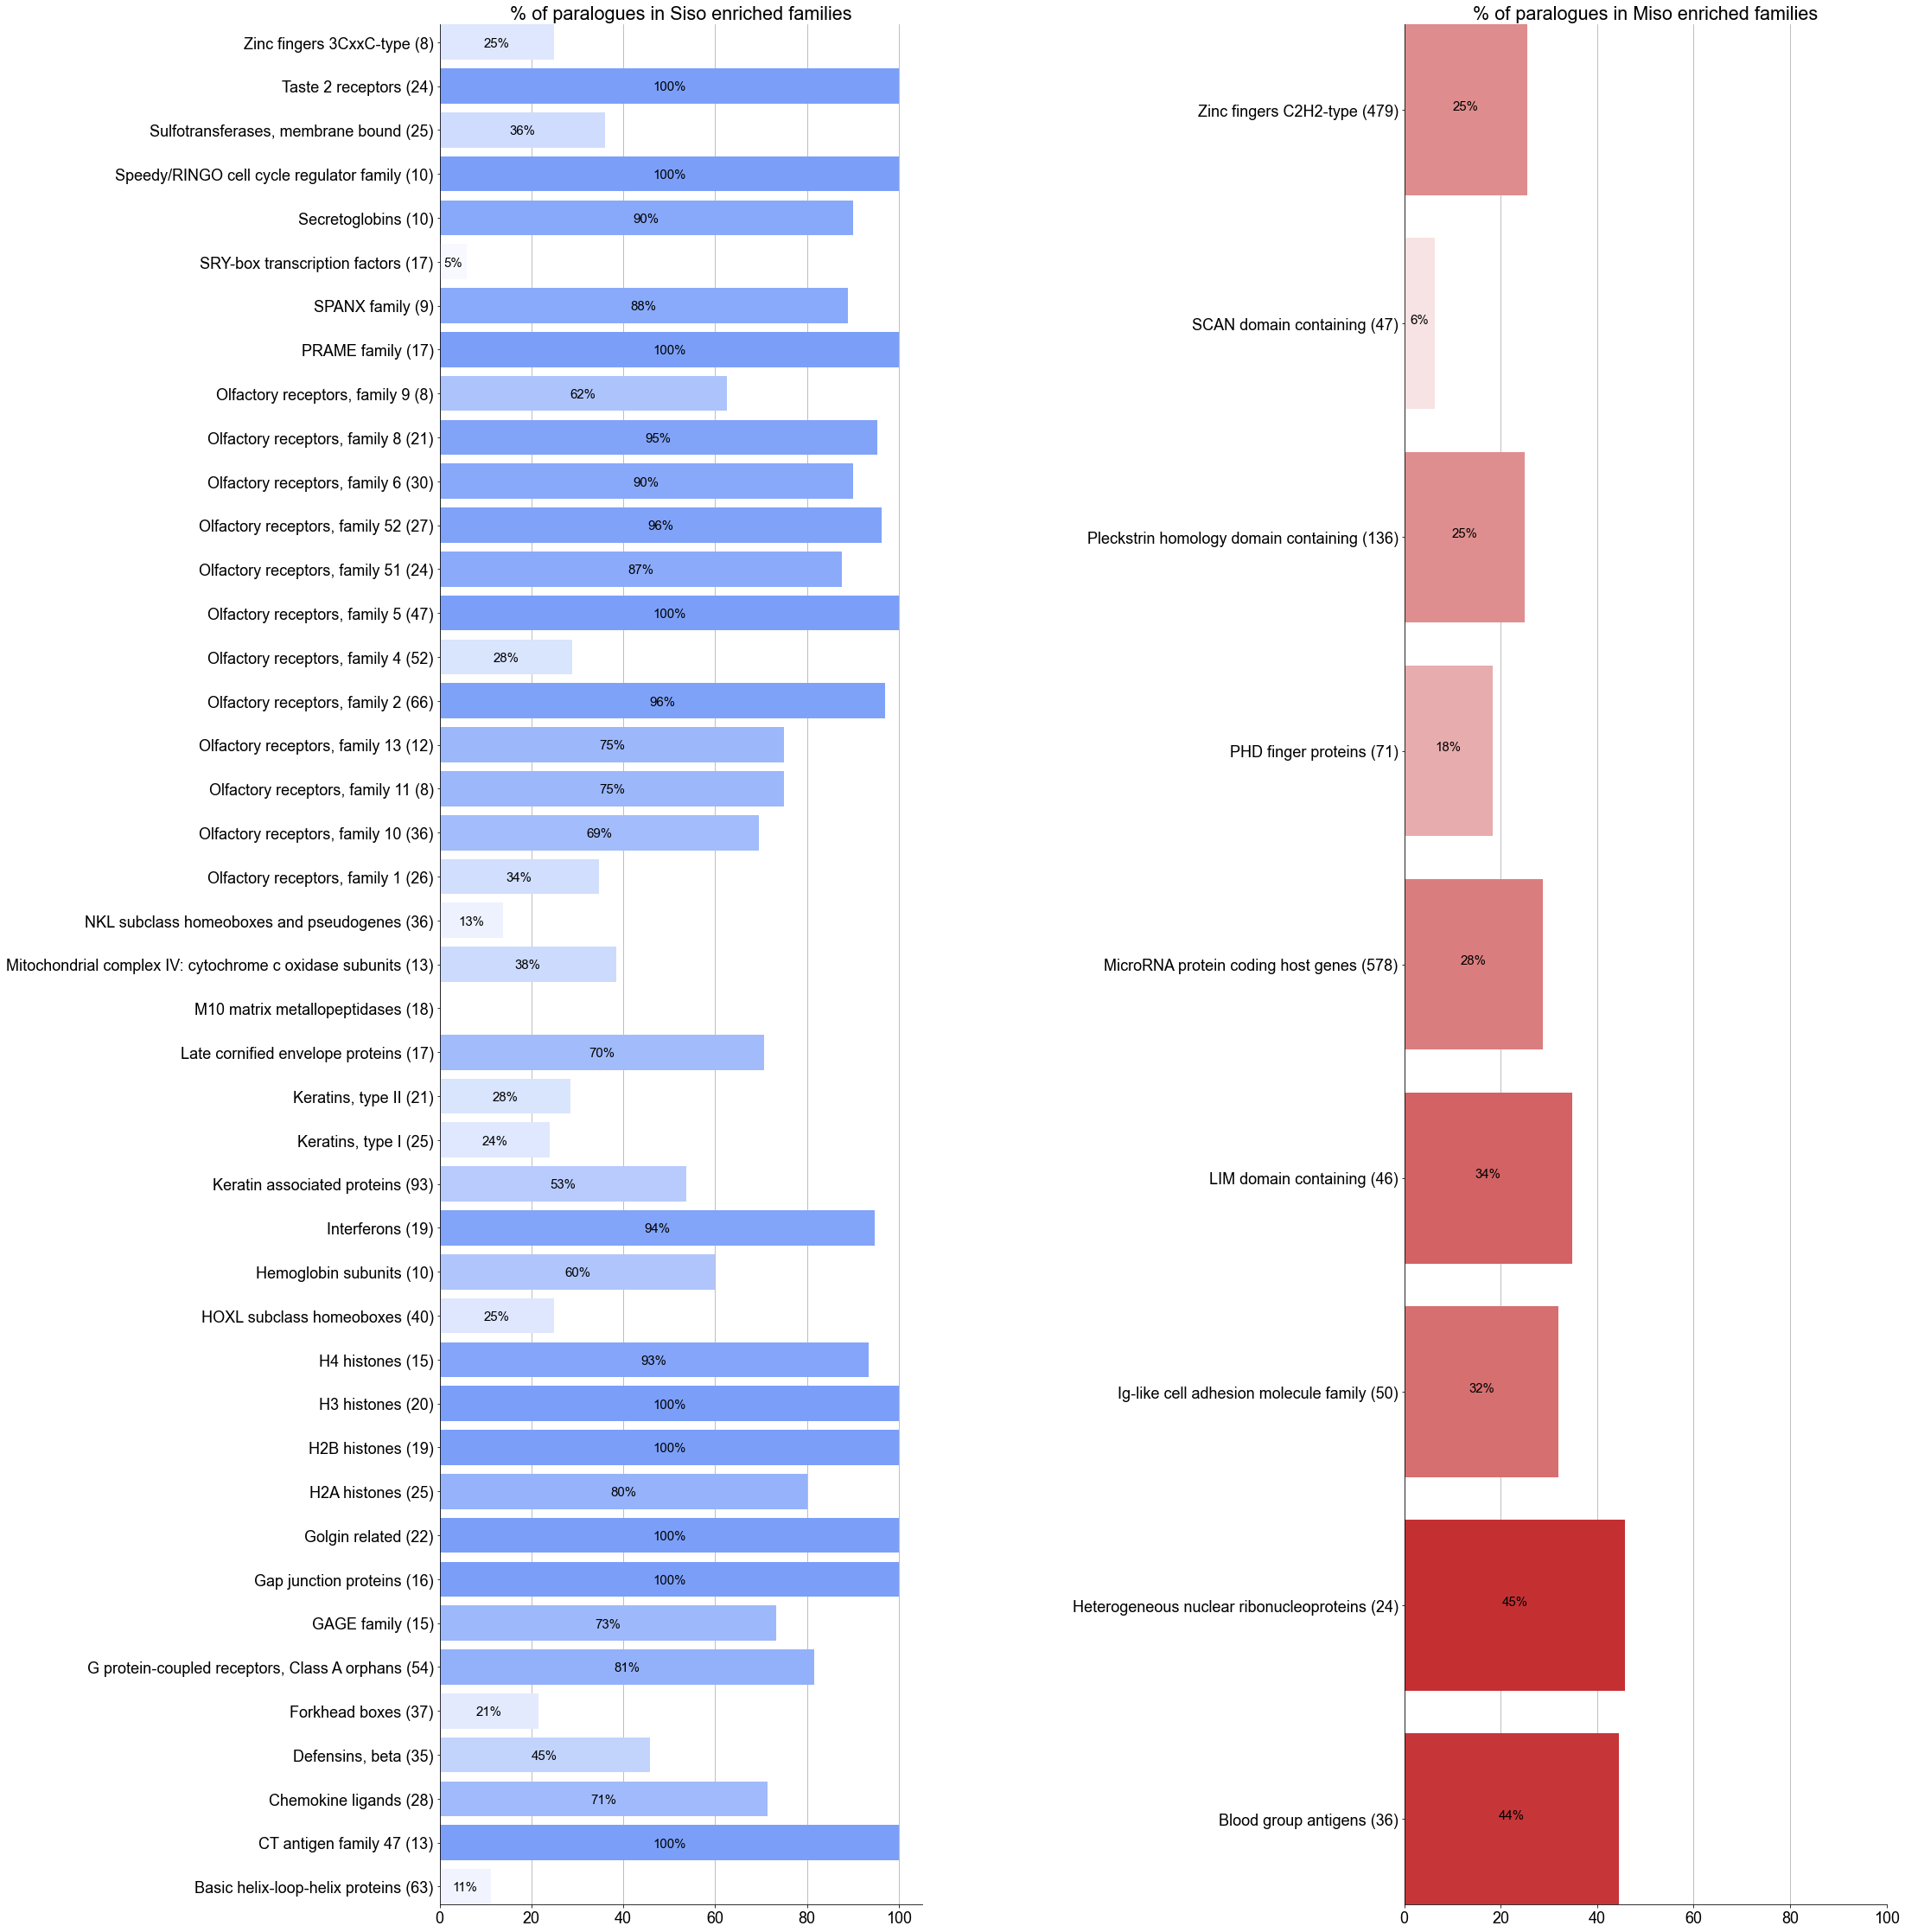

In [23]:
def show_values_on_bars(axs, padding=0.1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}%".format(int(p.get_width()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if value != "0%":
                ax.text(_x, _y-padding, value, ha="center", size="small", rotation=rotation, color='black', weight='semibold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

import matplotlib.colors as mcolors

hgnc_siso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_siso.index.tolist())]

paralogs_siso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_siso_enriched.Gene.values.tolist())]
paralogs_siso_enriched = paralogs_siso_enriched.loc[paralogs_siso_enriched['Miso_siso'] == 'Siso'].drop_duplicates(subset=['Gene'])
paralogs_siso_enriched = pd.merge(paralogs_siso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_siso_enriched = paralogs_siso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_siso_enriched_count = hgnc_siso_enriched.loc[hgnc_siso_enriched['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()


f, ax = plt.subplots(ncols=2, figsize=(30,40))

merge = pd.merge(hgnc_siso_enriched_count, paralogs_siso_enriched, on='gene_family', how='left').fillna(0)
merge['Ratio'] = 100 * (merge['count'] / merge['Total'])
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", palette['Siso']])

merge_plot = merge[['gene_family', 'Ratio']].set_index('gene_family').sort_values(by='gene_family', ascending=True)
merge_count = merge[['gene_family', 'Total']].set_index('gene_family').sort_values(by='gene_family', ascending=True)
ax[0].barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()),)
# ax.barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()))
ax[0].set_title('% of paralogues in Siso enriched families')
show_values_on_bars(ax[0])
ax[0].margins(y=0)

# ax[1].barh(merge_count.index.tolist(), merge_count.Total.values.tolist(), color=cmap(merge_count.Total.values/merge_count.Total.values.max()),)
merge['Label'] = merge.gene_family + ' (' + merge['Total'].astype(str) + ')'
ax[0].set_yticklabels(merge.Label.values.tolist())


hgnc_miso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_miso.index.tolist())]

paralogs_miso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_miso_enriched.Gene.values.tolist())]
paralogs_miso_enriched = paralogs_miso_enriched.loc[paralogs_miso_enriched['Miso_siso'] == 'Miso'].drop_duplicates(subset=['Gene'])
paralogs_miso_enriched = pd.merge(paralogs_miso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_miso_enriched = paralogs_miso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_miso_enriched_count = hgnc_miso_enriched.loc[hgnc_miso_enriched['Miso_siso'] == 'Miso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()



merge = pd.merge(hgnc_miso_enriched_count, paralogs_miso_enriched, on='gene_family', how='left').fillna(0)
merge['Ratio'] = 100 * (merge['count'] / merge['Total'])
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", palette['Miso']])

merge_plot = merge[['gene_family', 'Ratio']].set_index('gene_family').sort_values(by='gene_family', ascending=True)
ax[1].barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()))
ax[1].set_title('% of paralogues in Miso enriched families')
ax[1].set_xlim(0,100)
merge['Label'] = merge.gene_family + ' (' + merge['Total'].astype(str) + ')'
ax[1].set_yticklabels(merge.Label.values.tolist())

show_values_on_bars(ax[1], padding=0)


for j, sub_ax in enumerate(ax):
#     if j % 2 == 0:
    sub_ax.spines['right'].set_linewidth(0)
    sub_ax.spines['top'].set_linewidth(0)
    sub_ax.set_ylabel('')
    sub_ax.grid(axis='x')
    sub_ax.set_axisbelow(True)
#         sub_ax.set_xlabel('% paralogs in family')

plt.subplots_adjust(wspace=1)
ax[1].margins(y=0)
merge_plot

In [46]:
hgnc_olfactory = hgnc.copy()
hgnc_olfactory['gene_family'] = hgnc_olfactory['gene_family'].str.split('|')
hgnc_olfactory = hgnc_olfactory[['symbol', 'gene_family']]
hgnc_olfactory = hgnc_olfactory.explode('gene_family')
hgnc_olfactory = hgnc_olfactory.dropna(subset=['gene_family'])
hgnc_olfactory = hgnc_olfactory.loc[hgnc_olfactory['gene_family'].str.contains('Olfactory')]
hgnc_olfactory.symbol.nunique()

406

In [47]:
hgnc_miso_siso_dropna = hgnc_miso_siso.dropna(subset=['gene_family'])
hgnc_miso_siso_dropna.loc[hgnc_miso_siso_dropna['gene_family'].str.contains('Olfactory')].Gene.nunique()

390

In [49]:
hgnc_miso_siso_dropna.loc[(hgnc_miso_siso_dropna['gene_family'].str.contains('Olfactory')) & (hgnc_miso_siso_dropna['Miso_siso'] == 'Siso')].Gene.nunique()

384

Miso_siso
Miso    28.719723
Siso    75.000000
Name: Ratio, dtype: float64
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.285e-03 U_stat=7.800e+01


,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,9.0,28.993631,12.342408,6.382979,25.000000,28.719723,34.782609,45.833333
Siso,43.0,66.144545,32.509323,0.000000,35.307692,75.000000,95.767196,100.000000


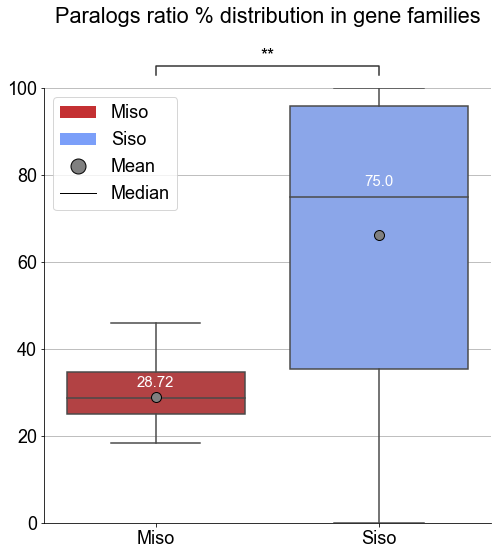

In [52]:
def show_values_on_bars(axs, padding=0.1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}%".format(int(p.get_width()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            if value != "0%":
                ax.text(_x, _y-padding, value, ha="center", size="small", rotation=rotation, color='black', weight='semibold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

import matplotlib.colors as mcolors

hgnc_siso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_siso.index.tolist())]

paralogs_siso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_siso_enriched.Gene.values.tolist())]
paralogs_siso_enriched = paralogs_siso_enriched.loc[paralogs_siso_enriched['Miso_siso'] == 'Siso'].drop_duplicates(subset=['Gene'])
paralogs_siso_enriched = pd.merge(paralogs_siso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_siso_enriched = paralogs_siso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_siso_enriched_count = hgnc_siso_enriched.loc[hgnc_siso_enriched['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()


f, ax = plt.subplots(figsize=(8,8))

merge_siso = pd.merge(hgnc_siso_enriched_count, paralogs_siso_enriched, on='gene_family', how='left').fillna(0)
merge_siso['Ratio'] = 100 * (merge_siso['count'] / merge_siso['Total'])
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", palette['Siso']])

merge_plot = merge[['gene_family', 'Ratio']].set_index('gene_family').sort_values(by='gene_family', ascending=False)
# ax[0].barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()),)
# # ax.barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()))
# ax[0].set_title('% of paralogues in Siso enriched families')
# show_values_on_bars(ax[0])



hgnc_miso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_miso.index.tolist())]

paralogs_miso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_miso_enriched.Gene.values.tolist())]
paralogs_miso_enriched = paralogs_miso_enriched.loc[paralogs_miso_enriched['Miso_siso'] == 'Miso'].drop_duplicates(subset=['Gene'])
paralogs_miso_enriched = pd.merge(paralogs_miso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_miso_enriched = paralogs_miso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_miso_enriched_count = hgnc_miso_enriched.loc[hgnc_miso_enriched['Miso_siso'] == 'Miso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()



merge_miso = pd.merge(hgnc_miso_enriched_count, paralogs_miso_enriched, on='gene_family', how='left').fillna(0)
merge_miso['Ratio'] = 100 * (merge_miso['count'] / merge_miso['Total'])
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", palette['Miso']])

merge_plot = merge_miso[['gene_family', 'Ratio']].set_index('gene_family').sort_values(by='gene_family', ascending=False)


merge_siso['Miso_siso'] = 'Siso'
merge_miso['Miso_siso'] = 'Miso'

custom_boxplot(pd.concat([merge_siso, merge_miso]),"Miso_siso","Ratio",ax,(0,100),"Paralogs ratio % distribution in gene families",[("Siso", "Miso")], palette=palette, padding_title=65, padding_value_boxplot=-2.5, legend=True)
test = pd.concat([merge_siso, merge_miso])
test.groupby('Miso_siso')['Ratio'].describe()
                 
# ax[1].barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()))
# ax[1].set_title('% of paralogues in Miso enriched families')
# show_values_on_bars(ax[1])

# plt.tight_layout()

# for sub_ax in ax:
#     sub_ax.spines['right'].set_linewidth(0)
#     sub_ax.spines['top'].set_linewidth(0)
#     sub_ax.set_ylabel('')
#     sub_ax.grid(axis='x')
#     sub_ax.set_axisbelow(True)
#     sub_ax.set_xlabel('% paralogs in family')



In [295]:
hgnc_miso_siso.gene_family.nunique()

1325

,gene_family,Total,count,Ratio
0,7BS protein arginine methyltranferases,9,0.0,0.000000
1,7BS protein methyltransferases,7,4.0,0.571429
2,AAA ATPases,37,12.0,0.324324
3,ADAMTS like,6,0.0,0.000000
4,AH/BAR family Rho GTPase activating proteins,12,7.0,0.583333
...,...,...,...,...
66,V-set domain containing,101,49.0,0.485149
67,WD repeat domain containing,173,56.0,0.323699
68,WTAP complex,7,3.0,0.428571
69,Zinc fingers C2H2-type,407,105.0,0.257985


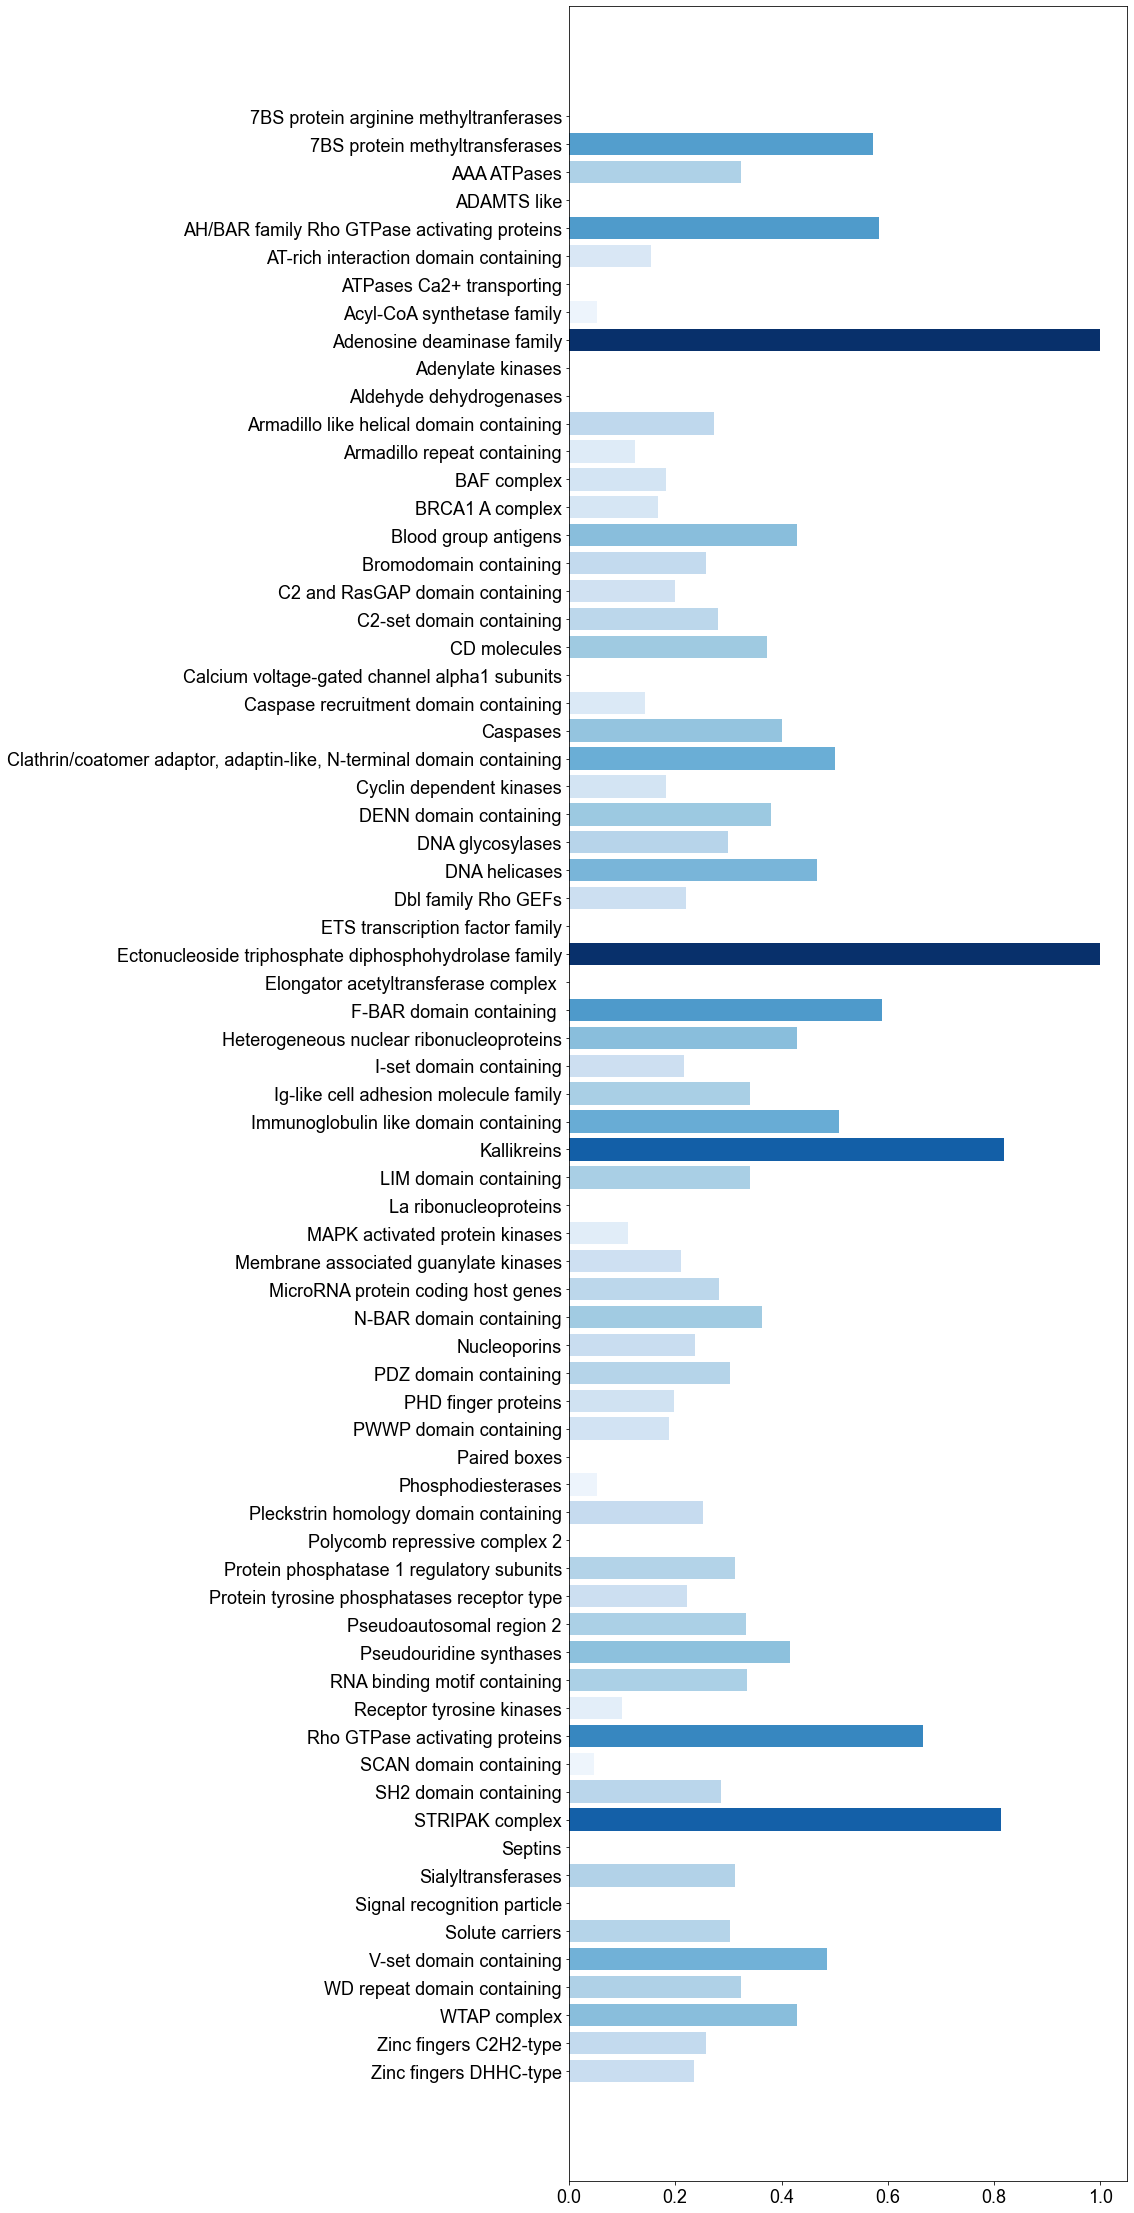

In [434]:
import matplotlib.colors as mcolors

hgnc_miso_enriched = hgnc_miso_siso.loc[hgnc_miso_siso['gene_family'].isin(count_stat_miso.index.tolist())]

paralogs_miso_enriched = paralogs.loc[paralogs['Gene'].isin(hgnc_miso_enriched.Gene.values.tolist())]
paralogs_miso_enriched = paralogs_miso_enriched.loc[paralogs_miso_enriched['Miso_siso'] == 'Miso'].drop_duplicates(subset=['Gene'])
paralogs_miso_enriched = pd.merge(paralogs_miso_enriched, hgnc_miso_siso[['Gene', 'gene_family']], on='Gene')
paralogs_miso_enriched = paralogs_miso_enriched.groupby('gene_family')['Miso_siso'].count().rename('count').reset_index()

hgnc_miso_enriched_count = hgnc_miso_enriched.loc[hgnc_miso_enriched['Miso_siso'] == 'Miso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()


f, ax = plt.subplots(figsize=(10,40))

merge = pd.merge(hgnc_miso_enriched_count, paralogs_miso_enriched, on='gene_family', how='left').fillna(0)
merge['Ratio'] = merge['count'] / merge['Total']
cmap = plt.get_cmap('Blues')

merge_plot = merge[['gene_family', 'Ratio']].set_index('gene_family').sort_values(by='gene_family', ascending=False)
ax.barh(merge_plot.index.tolist(), merge_plot.Ratio.values.tolist(), color=cmap(merge_plot.Ratio.values/merge_plot.Ratio.values.max()))
merge

In [ ]:
pd.merge()

In [132]:
# f, ax = plt.subplots(figsize=(10,30))


stats_all_families_siso = hgnc_miso_siso.loc[hgnc_miso_siso['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()
hgnc_siso_enriched_count = hgnc_siso_enriched.loc[hgnc_siso_enriched['Miso_siso'] == 'Siso'].groupby('gene_family')['Miso_siso'].count().rename('Total').reset_index()
# merge = pd.merge(stats_all_families_siso, hgnc_siso_enriched_count, on='gene_family')
# merge['Ratio'] = merge['count'] / merge['Total']
# merge[['gene_family', 'Ratio']].plot.barh(ax=ax)

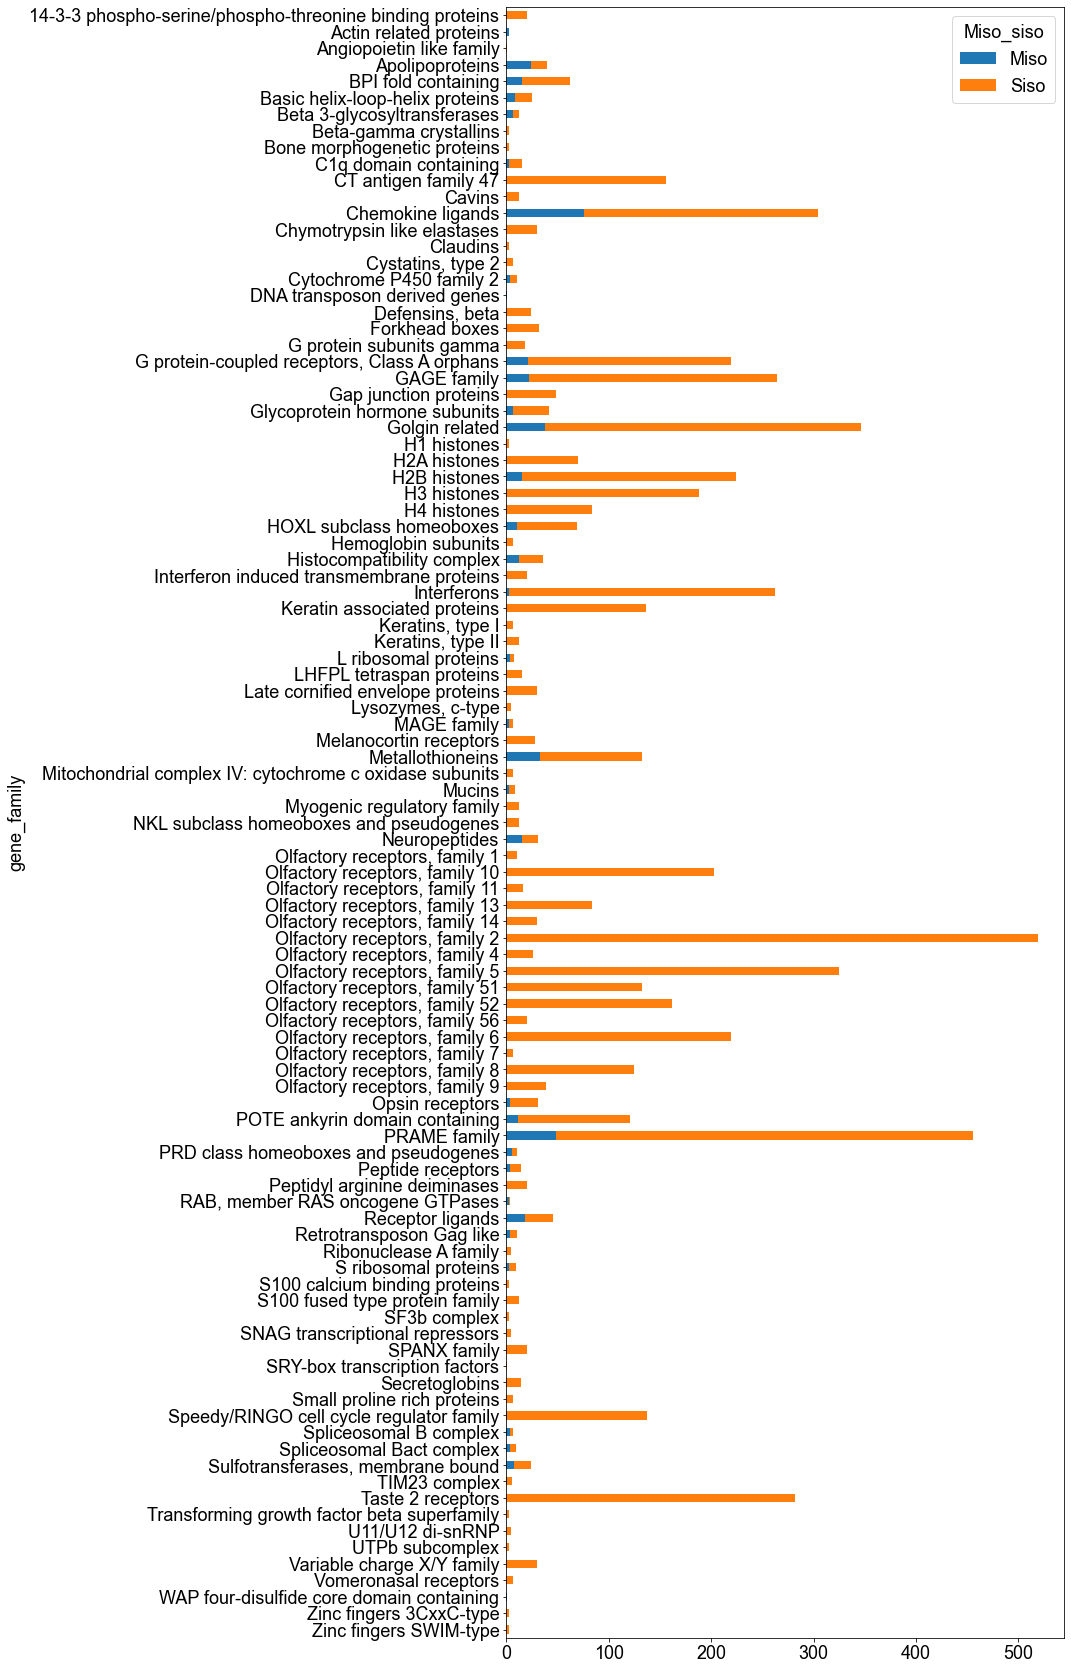

In [82]:
f, ax = plt.subplots(figsize=(10,30))

paralogs_families = pd.merge(paralogs, hgnc_siso_enriched.drop(['Miso_siso'], axis=1), on='Gene').groupby('gene_family')['Miso_siso'].value_counts().rename('count').reset_index()
paralogs_families.pivot(index='gene_family', columns='Miso_siso', values='count').fillna(0).sort_values(by='gene_family', ascending=False).plot.barh(ax=ax, stacked=True)

In [303]:
hk = pd.read_csv('/gstock/EXOTIC/data/HK/Housekeeping_GenesHuman.csv', sep=';').rename({'Gene.name' : 'Gene'}, axis=1).drop_duplicates(subset=['Gene'])
hk = pd.merge(genes[['Gene', 'Miso_siso']], hk, on='Gene')
hk

,Gene,Miso_siso,Ensembl,Refseq,CCDS.ID
0,NOC2L,Siso,ENST00000327044,NM_015658,CCDS3
1,SDF4,Miso,ENST00000360001,NM_016176,CCDS30553
2,DVL1,Miso,ENST00000378891,NM_004421,CCDS22
3,AURKAIP1,Miso,ENST00000338338,NM_017900,CCDS25
4,CCNL2,Miso,ENST00000400809,NM_030937,CCDS30557
...,...,...,...,...,...
2140,GDI1,Siso,ENST00000447750,NM_001493,CCDS35452
2141,FAM50A,Siso,ENST00000393600,NM_004699,CCDS14751
2142,UBL4A,Siso,ENST00000369660,NM_014235,CCDS14754
2143,DKC1,Miso,ENST00000369550,NM_001142463; NM_001363,CCDS14761


In [309]:
paralogs.Check_paralog.value_counts()

True    19454
Name: Check_paralog, dtype: int64

In [319]:
hk = pd.read_csv('/gstock/EXOTIC/data/HK/Housekeeping_GenesHuman.csv', sep=';').rename({'Gene.name' : 'Gene'}, axis=1).drop_duplicates(subset=['Gene'])
hk.Gene.nunique()

2176

In [54]:
hk = pd.read_csv('/gstock/EXOTIC/data/HK/Housekeeping_GenesHuman.csv', sep=';').rename({'Gene.name' : 'Gene'}, axis=1)
hk = pd.merge(genes[['Gene', 'Miso_siso']], hk['Gene'], on='Gene', how='right').drop_duplicates()
hk = pd.merge(paralogs[['Gene', 'Check_paralog']], hk, on='Gene', how='right').drop_duplicates()
hk['Check_paralog'] = hk['Check_paralog'].fillna(False)
hk

,Gene,Check_paralog,Miso_siso
0,ARF5,False,Siso
1,M6PR,False,Miso
2,RALA,False,Siso
3,DVL2,True,Siso
6,RHBDD2,False,Miso
...,...,...,...
2790,DNAJC3,False,Siso
2791,NCBP2-AS2,False,NaN
2792,NDUFB1,False,Siso
2793,WDR6,False,Miso


In [329]:
hk.Gene.nunique()

2176

In [332]:
hk.Miso_siso.value_counts()

Miso    1208
Siso     935
Name: Miso_siso, dtype: int64

In [310]:
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")

paralogs = pd.read_csv(yaml['2_PARALOGS']['External']['biomart_paralogs'], compression='gzip', sep='\t')
paralogs = paralogs.dropna(subset=['Human paralogue chromosome/scaffold start (bp)'])
# paralogs = paralogs.dropna(subset=['Human paralogue chromosome/scaffold start (bp)', 'Human paralogue gene stable ID'])
paralogs = paralogs.dropna(subset=['Human paralogue associated gene name'])

paralogs = pd.merge(paralogs.rename({'Gene name':'Gene'},axis=1), genes[['Gene', 'Miso_siso']], on='Gene')
paralogs = paralogs.loc[paralogs['Human paralogue homology type'] == 'within_species_paralog']
# paralogs = paralogs.loc[paralogs['Paralogue last common ancestor with Human'] == 'Homo sapiens']
paralogs['Check_paralog'] = paralogs['Human paralogue associated gene name'].apply(lambda r: True if type(r) is str else False)
# paralogs['Association'] = paralogs.apply(lambda r:list(sorted([r['Human paralogue associated gene name'] + r['Gene']])), axis=1)
paralogs

,Gene stable ID,Gene stable ID version,Human paralogue associated gene name,Human paralogue gene stable ID,Human paralogue protein or transcript ID,Human paralogue chromosome/scaffold name,Human paralogue chromosome/scaffold start (bp),Human paralogue chromosome/scaffold end (bp),Paralogue query protein or transcript ID,Paralogue last common ancestor with Human,Human paralogue homology type,Paralogue %id. target Human gene identical to query gene,Paralogue %id. query gene identical to target Human gene,Gene,Miso_siso,Check_paralog
0,ENSG00000233803,ENSG00000233803.9,TSPY10,ENSG00000236424,ENSP00000406407,Y,9527880.0,9530682.0,ENSP00000399668,Homo sapiens,within_species_paralog,98.0892,100.0000,TSPY4,Siso,True
1,ENSG00000233803,ENSG00000233803.9,TSPY3,ENSG00000228927,ENSP00000398163,Y,9398421.0,9401223.0,ENSP00000399668,Homo sapiens,within_species_paralog,98.0892,100.0000,TSPY4,Siso,True
2,ENSG00000233803,ENSG00000233803.9,TSPY9P,ENSG00000238074,ENSP00000499192,Y,9487313.0,9489893.0,ENSP00000399668,Homo sapiens,within_species_paralog,99.6815,99.6815,TSPY4,Siso,True
3,ENSG00000233803,ENSG00000233803.9,TSPY8,ENSG00000229549,ENSP00000287721,Y,9357797.0,9360599.0,ENSP00000399668,Homo sapiens,within_species_paralog,97.4522,99.3506,TSPY4,Siso,True
4,ENSG00000233803,ENSG00000233803.9,TSPY2,ENSG00000168757,ENSP00000314077,Y,6246223.0,6249019.0,ENSP00000399668,Homininae,within_species_paralog,97.4522,99.3506,TSPY4,Siso,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253440,ENSG00000196242,ENSG00000196242.10,OR2J1,ENSG00000204702,ENSP00000493312,6,29099490.0,29102701.0,ENSP00000493385,Theria,within_species_paralog,55.3125,56.7308,OR2C3,Siso,True
253730,ENSG00000196182,ENSG00000196182.11,TRIB3,ENSG00000101255,ENSP00000217233,20,362835.0,397559.0,ENSP00000362224,Chordata,within_species_paralog,23.6782,28.7710,STK40,Miso,True
253731,ENSG00000196182,ENSG00000196182.11,TRIB1,ENSG00000173334,ENSP00000312150,8,125430358.0,125438403.0,ENSP00000362224,Chordata,within_species_paralog,22.7586,26.6129,STK40,Miso,True
253732,ENSG00000196182,ENSG00000196182.11,TRIB2,ENSG00000071575,ENSP00000155926,2,12716910.0,12742734.0,ENSP00000362224,Chordata,within_species_paralog,22.0690,27.9883,STK40,Miso,True


In [334]:
print(hk.Gene.nunique())
hk.groupby(['Miso_siso', 'Check_paralog'])['Gene'].count()

2176


Miso_siso  Check_paralog
Miso       False            843
           True             365
Siso       False            719
           True             216
Name: Gene, dtype: int64

In [56]:
hk

,Gene,Check_paralog,Miso_siso
0,ARF5,False,Siso
1,M6PR,False,Miso
2,RALA,False,Siso
3,DVL2,True,Siso
6,RHBDD2,False,Miso
...,...,...,...
2790,DNAJC3,False,Siso
2791,NCBP2-AS2,False,NaN
2792,NDUFB1,False,Siso
2793,WDR6,False,Miso


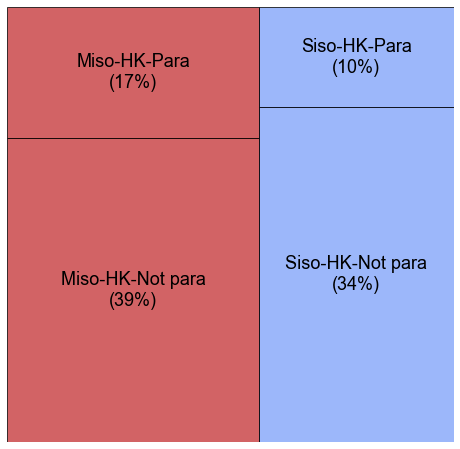

In [55]:
#libraries
# import matplotlib.pyplot as plt
 
data = hk.groupby(['Miso_siso', 'Check_paralog']).count().reset_index()
data['label'] = data['Miso_siso'] + '-' + data['Check_paralog'].astype(str)



values = data.Gene.values.tolist()
labels = ["Miso-HK-Not para" , 'Miso-HK-Para' , 'Siso-HK-Not para', 'Siso-HK-Para']
labels = ["{}\n({}%)".format(e,int(100*round(j/sum(values),2))) for e,j in zip(labels, values)]
    
f, ax= plt.subplots(figsize=(8,8))
    
# Change color
squarify.plot(sizes=values, 
              label=labels, 
              color=[palette['Miso'], palette['Miso'], palette['Siso'], palette['Siso']], alpha=.75, edgecolor='black', ax=ax)
plt.axis('off')
plt.show()

In [65]:
hgnc_lite.loc[(hgnc_lite['gene_family'].isin(count_stat_siso.index.tolist()))]

,hgnc_id,symbol,name,gene_family,gene_family_id
459,HGNC:348,AHR,aryl hydrocarbon receptor,Basic helix-loop-helix proteins,420
460,HGNC:346,AHRR,aryl-hydrocarbon receptor repressor,Basic helix-loop-helix proteins,420
1054,HGNC:700,ARNT,aryl hydrocarbon receptor nuclear translocator,Basic helix-loop-helix proteins,420
1055,HGNC:16876,ARNT2,aryl hydrocarbon receptor nuclear translocator 2,Basic helix-loop-helix proteins,420|1691
1056,HGNC:701,ARNTL,aryl hydrocarbon receptor nuclear translocator...,Basic helix-loop-helix proteins,420
...,...,...,...,...,...
18311,HGNC:10645,XCL1,X-C motif chemokine ligand 1,Chemokine ligands,483
18312,HGNC:10646,XCL2,X-C motif chemokine ligand 2,Chemokine ligands,483
18406,HGNC:20436,ZAR1,zygote arrest 1,Zinc fingers 3CxxC-type,137
18407,HGNC:37116,ZAR1L,zygote arrest 1 like,Zinc fingers 3CxxC-type,137


In [84]:
tmp = pd.merge(hgnc_lite.loc[(hgnc_lite['gene_family'].isin(count_stat_siso.index.tolist()))].rename({'symbol' : 'Gene'}, axis=1), genes[['Gene', 'Miso_siso']], on='Gene')
print(tmp.shape, tmp.gene_family.nunique(), tmp.Gene.nunique())
tmp.loc[(tmp['Miso_siso'] == 'Siso') & (tmp['Gene'].isin(hk.Gene.values.tolist()))].groupby('gene_family')['Gene'].count().rename('count').reset_index()

(1314, 6) 43 1313


,gene_family,count
0,Basic helix-loop-helix proteins,1
1,Forkhead boxes,1
2,Mitochondrial complex IV: cytochrome c oxidase...,7


In [85]:
tmp = pd.merge(hgnc_lite.loc[(hgnc_lite['gene_family'].isin(count_stat_miso.index.tolist()))].rename({'symbol' : 'Gene'}, axis=1), genes[['Gene', 'Miso_siso']], on='Gene')
print(tmp.shape, tmp.gene_family.nunique(), tmp.Gene.nunique())
tmp.loc[(tmp['Miso_siso'] == 'Miso') & (tmp['Gene'].isin(hk.Gene.values.tolist()))].groupby('gene_family')['Gene'].count().rename('count').reset_index()


(2087, 6) 9 1973


,gene_family,count
0,Blood group antigens,4
1,Heterogeneous nuclear ribonucleoproteins,14
2,LIM domain containing,2
3,MicroRNA protein coding host genes,67
4,PHD finger proteins,9
5,Pleckstrin homology domain containing,7
6,SCAN domain containing,2
7,Zinc fingers C2H2-type,15


In [72]:
tmp = pd.merge(hgnc_lite.loc[(hgnc_lite['gene_family'].isin(count_stat_siso.index.tolist()))].rename({'symbol' : 'Gene'}, axis=1), genes[['Gene', 'Miso_siso']], on='Gene')
tmp.loc[tmp['Miso_siso'] == 'Siso']

,hgnc_id,Gene,name,gene_family,gene_family_id,Miso_siso
0,HGNC:348,AHR,aryl hydrocarbon receptor,Basic helix-loop-helix proteins,420,Siso
3,HGNC:16876,ARNT2,aryl hydrocarbon receptor nuclear translocator 2,Basic helix-loop-helix proteins,420|1691,Siso
6,HGNC:738,ASCL1,achaete-scute family bHLH transcription factor 1,Basic helix-loop-helix proteins,420,Siso
7,HGNC:739,ASCL2,achaete-scute family bHLH transcription factor 2,Basic helix-loop-helix proteins,420,Siso
8,HGNC:740,ASCL3,achaete-scute family bHLH transcription factor 3,Basic helix-loop-helix proteins,420,Siso
...,...,...,...,...,...,...
1309,HGNC:10645,XCL1,X-C motif chemokine ligand 1,Chemokine ligands,483,Siso
1310,HGNC:10646,XCL2,X-C motif chemokine ligand 2,Chemokine ligands,483,Siso
1311,HGNC:20436,ZAR1,zygote arrest 1,Zinc fingers 3CxxC-type,137,Siso
1312,HGNC:37116,ZAR1L,zygote arrest 1 like,Zinc fingers 3CxxC-type,137,Siso


In [339]:
hk

,Gene,Check_paralog,Miso_siso
0,ARF5,False,Siso
1,M6PR,False,Miso
2,RALA,False,Siso
3,DVL2,True,Siso
6,RHBDD2,False,Miso
...,...,...,...
2790,DNAJC3,False,Siso
2791,NCBP2-AS2,False,NaN
2792,NDUFB1,False,Siso
2793,WDR6,False,Miso


In [352]:
merge_hk

,Total,count,R%
gene_family,,,
V-set domain containing,156,1,0.641026
C-type lectin domain containing,82,1,1.219512
I-set domain containing,149,2,1.342282
Dbl family Rho GEFs,68,1,1.470588
Sushi domain containing,56,1,1.785714
LIM domain containing,48,1,2.083333
Forkhead boxes,47,1,2.127660
Kinesins,44,1,2.272727
Kelch like,41,1,2.439024


In [450]:
merge_hk.shape

(50, 3)

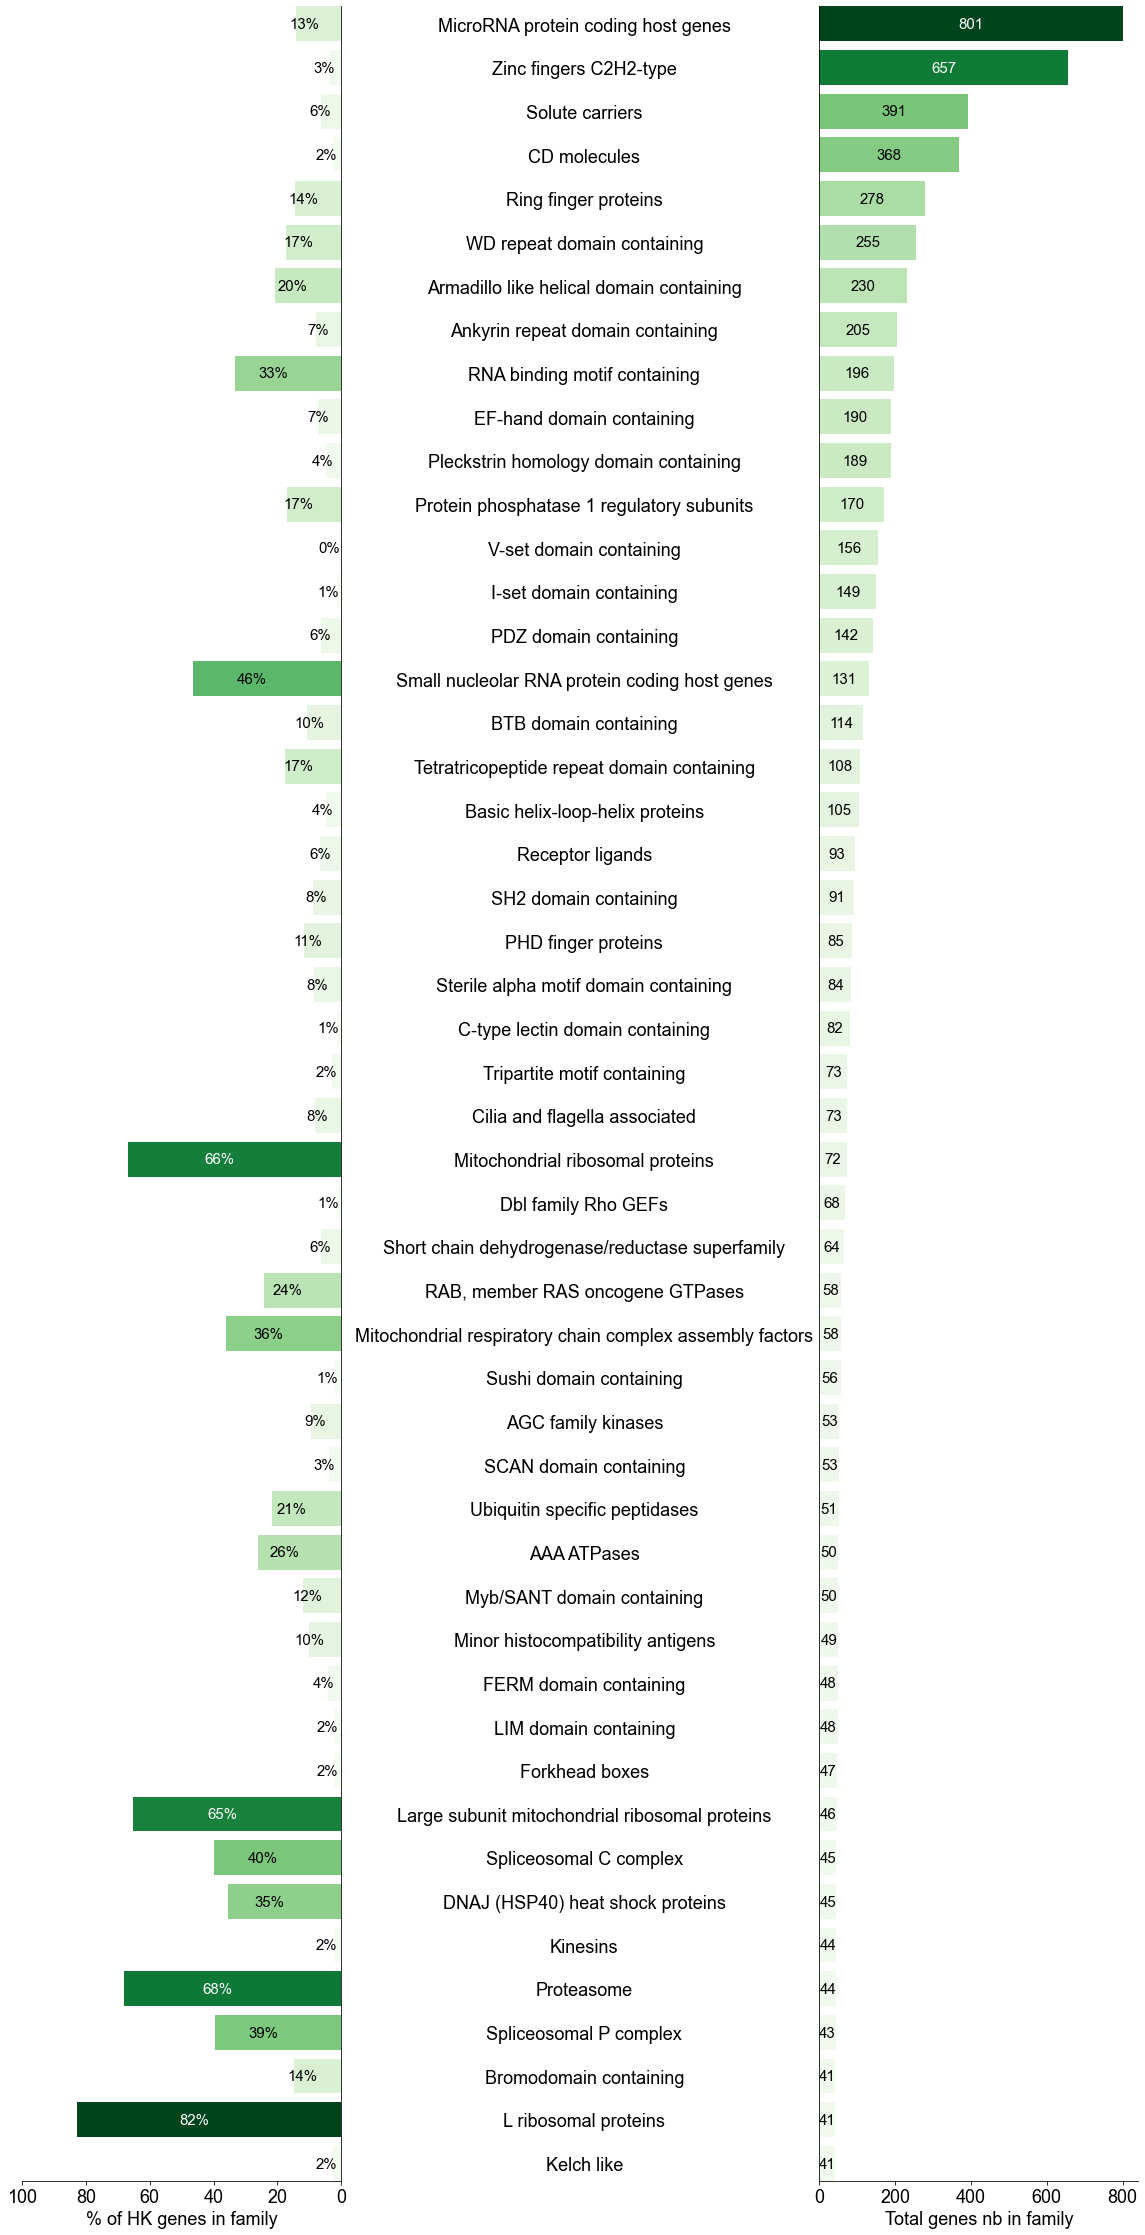

In [536]:
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, extrachar="", cutoff=0, align='center'):
    def _show_on_single_plot(ax):
        for j, p in enumerate(ax.patches):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2) - 0.1
            if i == 0:

                value = "{:,}".format(int(p.get_width())) + extrachar
            if i == 2:
                value = "{:.2f}".format(p.get_width())

            if i == 3:
                value = "{:.3f}".format(p.get_width())
            color = 'black' if p.get_width() < cutoff else 'white'
                
            ax.text(_x, _y, value, ha=align, size="small", rotation=rotation, color=color, weight='semibold')
#             ax.text(_x, _y - padding, "(" + str(int(100 * round(float(int(p.get_height())/s_sum[j]), 2))) + '%)', ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

merge_hk = pd.merge(
    pd.DataFrame(hgnc_miso_siso.groupby('gene_family')['Gene'].count().rename('Total')),
    pd.merge(hk, hgnc_miso_siso.drop(['Miso_siso'], axis=1), on='Gene').groupby(['gene_family'])['Gene'].count().rename('count'),
    on='gene_family'
)

merge_hk

merge_hk['R%'] = 100*(merge_hk['count'] / merge_hk['Total'])

merge_hk = merge_hk.sort_values(by='Total', ascending=False).head(50).sort_values(by="Total", ascending=True)

# cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "black", "green"])
cmap = plt.get_cmap('Greens')


f, ax = plt.subplots(ncols=2, figsize=(20,40))
ax[0].barh(merge_hk.index.tolist(), merge_hk['R%'].values.tolist(), color=cmap(merge_hk['R%'].values/merge_hk['R%'].values.max()))
# ax[0].spines['right'].set_linewidth(0)
ax[0].spines['top'].set_linewidth(0)
ax[0].invert_xaxis()
ax[0].set_ylabel("")
ax[0].margins(y=0)
ax[0].set_xlim(100, 0)
ax[0].set_xlabel('% of HK genes in family')
show_values_on_bars(ax[0], extrachar="%", cutoff=60, align='right')

# merge_hk['Total'].plot.barh(ax=ax[1])
ax[1].barh(merge_hk.index.tolist(), merge_hk['Total'].values.tolist(), color=cmap(merge_hk['Total'].values/merge_hk['Total'].values.max()))

ax[0].set_yticklabels([])
ax[1].set_yticklabels(merge_hk.index.tolist(), ha='center')
ax[1].tick_params(axis='y', which='major', pad=235, length=0)


ax[1].set_ylabel("")
ax[0].yaxis.set_ticks_position('none') 
ax[0].spines['left'].set_linewidth(0)
ax[1].spines['top'].set_linewidth(0)
ax[1].spines['right'].set_linewidth(0)
plt.subplots_adjust(wspace=1.5)

ax[1].margins(y=0)
ax[1].set_xlabel('Total genes nb in family')

show_values_on_bars(ax[1], cutoff=400, align='center')

    

In [345]:
pd.merge(hk, hgnc_miso_siso.drop(['Miso_siso'], axis=1), on='Gene').groupby(['gene_family'])['Gene'].count().rename('count')

gene_family
MicroRNA protein coding host genes                          112
RNA binding motif containing                                 65
Small nucleolar RNA protein coding host genes                61
Armadillo like helical domain containing                     48
Mitochondrial ribosomal proteins                             48
WD repeat domain containing                                  44
Ring finger proteins                                         40
L ribosomal proteins                                         34
Large subunit mitochondrial ribosomal proteins               30
Proteasome                                                   30
Protein phosphatase 1 regulatory subunits                    29
S ribosomal proteins                                         26
Zinc fingers C2H2-type                                       25
Solute carriers                                              24
Mitochondrial respiratory chain complex assembly factors     21
NADH:ubiquinone oxidoreducta

In [358]:
clinvar_lite = pd.read_parquet('/gstock/EXOTIC/data/VARIATIONS/clinvar_20210123_lite_table.parquet')
clinvar_lite

,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,OMIM_VARIANT_ID
0,SAMD11,1_865568_G_['A'],1,865568,G,['A'],missense_variant,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],None,824438,
1,SAMD11,1_865583_C_['T'],1,865583,C,['T'],missense_variant,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],None,959431,
2,SAMD11,1_865628_G_['A'],1,865628,G,['A'],missense_variant,Benign,Likely_benign,1,"criteria_provided,_single_submitter",[],41285790,707587,
3,SAMD11,1_865655_T_['G'],1,865655,T,['G'],missense_variant,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],None,959432,
4,SAMD11,1_865716_G_['A'],1,865716,G,['A'],missense_variant,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],None,824439,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770513,MT-CYB,MT_15873_T_['C'],MT,15873,T,['C'],missense_variant,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],1603225557,680861,
770514,MT-CYB,MT_15882_G_['A'],MT,15882,G,['A'],nonsense,Other,Uncertain_significance,1,"criteria_provided,_single_submitter",[],1603225560,680862,
770515,MT-CYB,MT_15884_G_['A'],MT,15884,G,['A'],missense_variant,Benign,Benign,1,"criteria_provided,_single_submitter",[HP:0100615],527236195,153625,
770516,MT-CYB,MT_15884_G_['C'],MT,15884,G,['C'],missense_variant,Benign,Benign,2,"criteria_provided,_multiple_submitters,_no_con...",[],527236195,247210,


In [364]:
clinvar_path = clinvar_lite.loc[(clinvar_lite['Status'] == 'Pathogenic') & (~clinvar_lite['CLNREVSTAT'].str.contains('onflicting'))]
clinvar_genes_path = clinvar_path.GENE.unique().tolist()
print(len(clinvar_genes_path), clinvar_genes_path[:10])
clinvar_path

4590 ['SAMD11', 'KLHL17', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'DVL1', 'MXRA8', 'VWA1', 'ATAD3A']


,GENE,VAR_ID,CHROM,POS,REF,ALT,MC,Status,Real_Status,RS_STARS,CLNREVSTAT,HPO,rs,alleleid,OMIM_VARIANT_ID
79,SAMD11,1_879375_C_['T'],1,879375,C,['T'],nonsense,Pathogenic,Pathogenic,1,"criteria_provided,_single_submitter",[],None,929884,
105,KLHL17,1_899892_C_['A'],1,899892,C,['A'],missense_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[HP:0002575],None,904889,
125,ISG15,1_949523_C_['T'],1,949523,C,['T'],nonsense,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],786201005,181485,147571.0003
138,ISG15,1_949696_C_['CG'],1,949696,C,['CG'],frameshift_variant,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],672601345,171289,147571.0002
141,ISG15,1_949739_G_['T'],1,949739,G,['T'],nonsense,Pathogenic,Pathogenic,0,no_assertion_criteria_provided,[],672601312,171288,147571.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770451,MT-CYB,MT_15637_C_['T'],MT,15637,C,['T'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236190,153620,
770457,MT-CYB,MT_15649_A_['G'],MT,15649,A,['G'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236191,153621,
770467,MT-CYB,MT_15670_T_['C'],MT,15670,T,['C'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[HP:0100615],193302997,153650,
770470,MT-CYB,MT_15682_A_['G'],MT,15682,A,['G'],synonymous_variant,Pathogenic,Likely_pathogenic,0,no_assertion_criteria_provided,[],527236192,153622,


In [454]:
clinvar_path = clinvar_lite.loc[(clinvar_lite['Status'] == 'Pathogenic') & (~clinvar_lite['CLNREVSTAT'].str.contains('onflicting'))]
clinvar_genes_path = clinvar_path.GENE.unique().tolist()
print(len(clinvar_genes_path), clinvar_genes_path[:10])
clinvar_path

genes.loc[genes['Gene'].isin(clinvar_genes_path), 'D/H'] = 'Disease'
genes.loc[~genes['Gene'].isin(clinvar_genes_path), 'D/H'] = 'Healthy'
genes

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Gene,Length,Miso_siso,D/H
0,NC_000001.10,BestRefSeq,gene,69091,70008,.,+,.,"ID=gene-OR4F5;Dbxref=GeneID:79501,HGNC:HGNC:14...",OR4F5,0.917,Siso,Healthy
1,NC_000001.10,BestRefSeq,gene,367659,368597,.,+,.,"ID=gene-OR4F29;Dbxref=GeneID:729759,HGNC:HGNC:...",OR4F29,0.938,Siso,Healthy
2,NC_000001.10,BestRefSeq,gene,621096,622034,.,-,.,"ID=gene-OR4F16;Dbxref=GeneID:81399,HGNC:HGNC:1...",OR4F16,0.938,Siso,Healthy
3,NC_000001.10,BestRefSeq,gene,861111,879954,.,+,.,"ID=gene-SAMD11;Dbxref=GeneID:148398,HGNC:HGNC:...",SAMD11,18.843,Siso,Disease
4,NC_000001.10,BestRefSeq,gene,879583,894636,.,-,.,"ID=gene-NOC2L;Dbxref=GeneID:26155,HGNC:HGNC:24...",NOC2L,15.053,Siso,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19319,NC_000024.9,BestRefSeq,gene,27177048,27198251,.,-,.,"ID=gene-BPY2C;Dbxref=GeneID:442868,HGNC:HGNC:1...",BPY2C,21.203,Siso,Healthy
19320,NC_000024.9,BestRefSeq,gene,27768264,27771049,.,+,.,"ID=gene-CDY1;Dbxref=GeneID:9085,HGNC:HGNC:1809...",CDY1,2.785,Miso,Healthy
19321,NC_000024.9,BestRefSeq,gene,59100403,59115127,.,+,.,"ID=gene-SPRY3-2;Dbxref=GeneID:10251,HGNC:HGNC:...",SPRY3,14.724,Miso,Healthy
19322,NC_000024.9,BestRefSeq,gene,59214014,59276439,.,+,.,"ID=gene-VAMP7-2;Dbxref=GeneID:6845,HGNC:HGNC:1...",VAMP7,62.425,Miso,Healthy


In [77]:
genes.groupby(['D/H', 'Miso_siso'])['Gene'].count().rename('count')

KeyError: 'D/H'

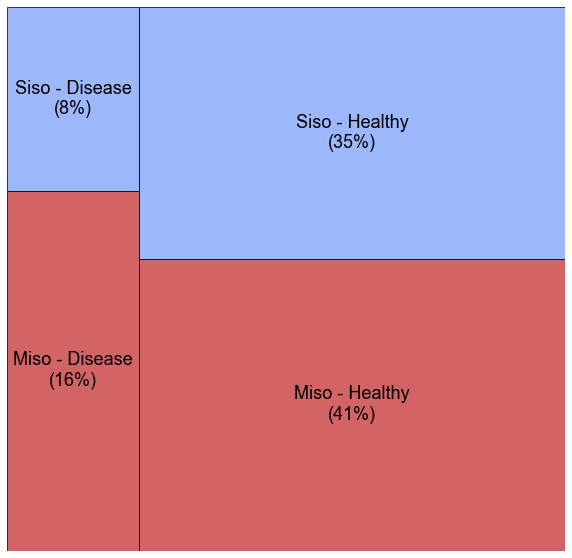

In [461]:
data = genes.groupby(['D/H', 'Miso_siso'])['Gene'].count().reset_index()

values = data.Gene.values.tolist()
labels = ["Miso - Disease" , 'Siso - Disease' , 'Miso - Healthy', 'Siso - Healthy']
labels = ["{}\n({}%)".format(e,int(100*round(j/sum(values),2))) for e,j in zip(labels, values)]
    
f, ax= plt.subplots(figsize=(10,10))
    
# Change color
squarify.plot(sizes=values, 
              label=labels, 
              color=[palette['Miso'], palette['Siso'], palette['Miso'], palette['Siso']], alpha=.75, edgecolor='black', ax=ax)
plt.axis('off')
plt.show()

[[3015, 1539], [7934, 6836]]
[10949, 8375, 10949, 8375]
Rectangle(xy=(-0.25, 0), width=0.5, height=3015, angle=0) 3015 [10949, 8375, 10949, 8375] 0.27536761348068317
Rectangle(xy=(0.75, 0), width=0.5, height=1539, angle=0) 1539 [10949, 8375, 10949, 8375] 0.18376119402985075
Rectangle(xy=(-0.25, 3015), width=0.5, height=7934, angle=0) 7934 [10949, 8375, 10949, 8375] 0.7246323865193168
Rectangle(xy=(0.75, 1539), width=0.5, height=6836, angle=0) 6836 [10949, 8375, 10949, 8375] 0.8162388059701493


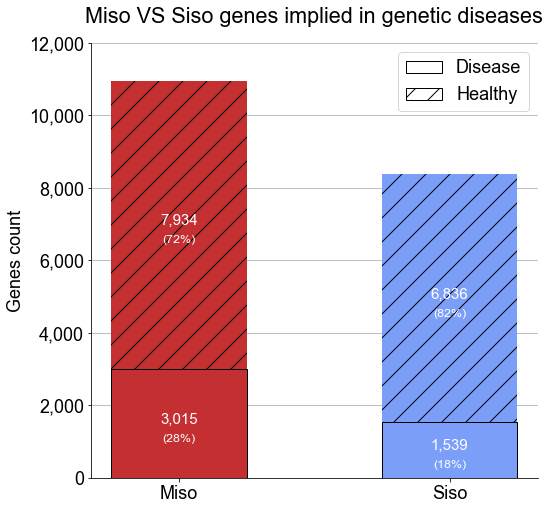

In [465]:
def show_values_on_bars(axs, padding=1, i=0, fontsize=13, rotation=0, ):
    def _show_on_single_plot(ax):
        s_sum = list()
        sub_list = list()
        i_c = 1
        for p in ax.patches:
            sub_list.append(p.get_height())
            if i_c % 2 == 0:
                s_sum.append(sub_list)
                sub_list = list()
            i_c += 1
        print(s_sum)
        s_sum = zip(s_sum[0], s_sum[1])
        s_sum = [sum(e) for e in s_sum]
        s_sum = s_sum + s_sum
        print(s_sum)
        for j, p in enumerate(ax.patches):
#                 print('\n')
            print(p, p.get_height(), s_sum, float(int(p.get_height())/s_sum[j]))
#                 print('\n')
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + (p.get_height() / 2)
            if i == 0:

                value = "{:,}".format(int(p.get_height()))
            if i == 2:
                value = "{:.2f}".format(p.get_height())

            if i == 3:
                value = "{:.3f}".format(p.get_height())
            ax.text(_x, _y, value, ha="center", size="small", rotation=rotation, color='white', weight='semibold')
            ax.text(_x, _y - padding, "(" + str(int(100 * round(float(int(p.get_height())/s_sum[j]), 2))) + '%)', ha="center", size="x-small", rotation=rotation, color='white', weight='semibold')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

data = genes.groupby(['Miso_siso', 'D/H'])['Gene'].count().reset_index().pivot(columns='D/H', index='Miso_siso', values='Gene')

labels = data.index.tolist()
men_means = data['Disease'].values.tolist()
women_means = data['Healthy'].values.tolist()
width = 0.5    

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(labels, men_means, width, label='Disease', color=[palette['Miso'], palette['Siso']],  edgecolor='black')
ax.bar(labels, women_means, width, bottom=men_means, label='Healthy', hatch="/", color=[palette['Miso'],  palette['Siso']])
ax.set_ylim(0,12e3)
ax.set_ylabel('Genes count')
ax.set_title('Miso VS Siso genes implied in genetic diseases', pad=20)

circ1 = mpatches.Patch( facecolor='white', edgecolor='black', label="Disease")
circ2= mpatches.Patch( facecolor='white', edgecolor='black',  hatch="/", label='Healthy')
ax.legend(handles=[circ1, circ2], loc='upper right')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
#     ax.spines['bottom'].set_linewidth(0)
ax.set_axisbelow(True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis='y')
show_values_on_bars(ax, padding=500)
